In [ ]:
## %matplotlib inline

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy import signal
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks, welch

# Calculus Exercise
## Numerical Computation. Derivatives, integrals. Calculus in many dimensions

### Problem 1. Derivative and Slope at a Point
We'll warm up by visualizing how the derivative of a function relates to the slope of the function at a given point.

We can either calculate the derivative analytically (by hand) or use the numerical definition. So, let's see what a function and its derivative look like.

Write a Python function which plots a math function and its derivative.

In [4]:
def calculate_derivative_at_point(function, point, precision = 1e-7):
    """
    Calculates a numerical approximation to the derivative of the specified function
    at the given point
    """
    return (function(point + precision) - function(point - precision)) / (2 * precision)

def plot_derivative(function, derivative = None, min_x = -10, max_x = 10):
    """
    Plots the function and its derivative. 
    The `derivative` parameter is optional and can be provided as a separate function.
    If it's not provided, the derivative will be calculated automatically
    """
    # We're using vectorized functions to make our code simpler: this only hides the for-loop,
    # it doesn't provide any performance gain
    vectorized_function = np.vectorize(function)
    
    x = np.linspace(min_x, max_x, 1000)
    y = vectorized_function(x)   #Generate the function values `y`
    
    dy = []
    if derivative is None:
        dy = np.vectorize(calculate_derivative_at_point)(function, x)
    else:
        dy = np.vectorize(derivative)(x)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot the original function
    plt.plot(x, y, label='Function f(x)', linewidth=2)
    
    # Plot the derivative
    plt.plot(x, dy, label="Derivative f'(x)", linewidth=2, linestyle='--')
    
    # Add labels and title
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title('Function and its Derivative', fontsize=14)
    
    # Add grid and legend
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.legend(fontsize=12)
    
    # Show the plot
    plt.show()

Let's now test with out favourite function: $y = x^2$ whose derivative is $y' = 2x$. If you've worked correctly, both of the following plots should be the same.

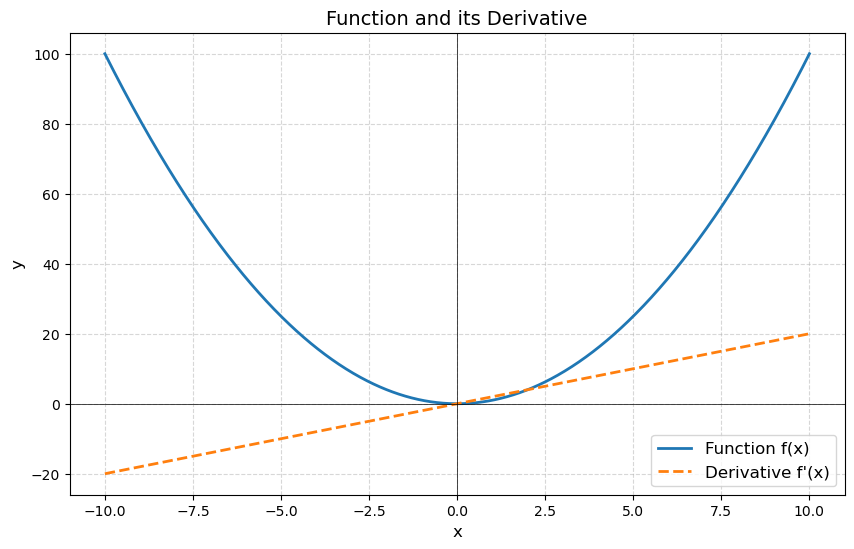

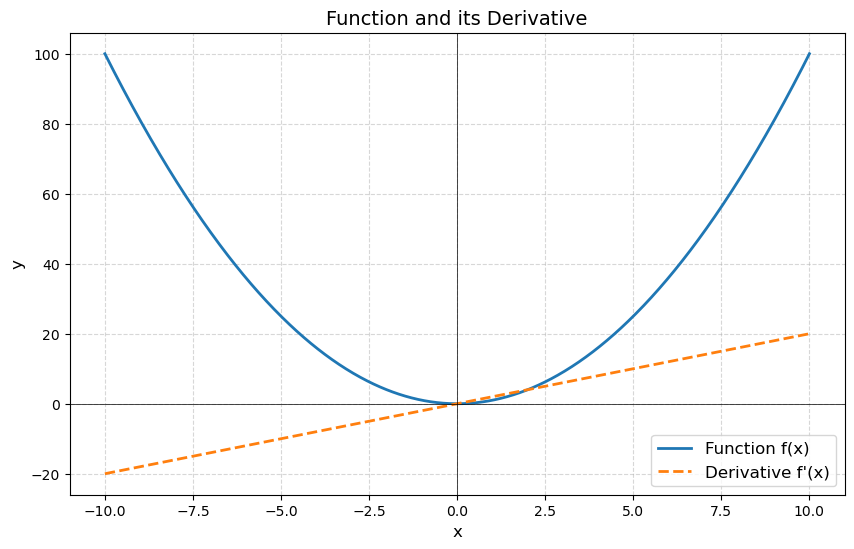

In [5]:
plot_derivative(lambda x: x ** 2, lambda x: 2 * x) # The derivative is calculated by hand
plot_derivative(lambda x: x ** 2) # The derivative is not pre-calculated, should be calculated inside the function

Let's try one more: $y = \sin(x)$, $y'= \cos(x)$.

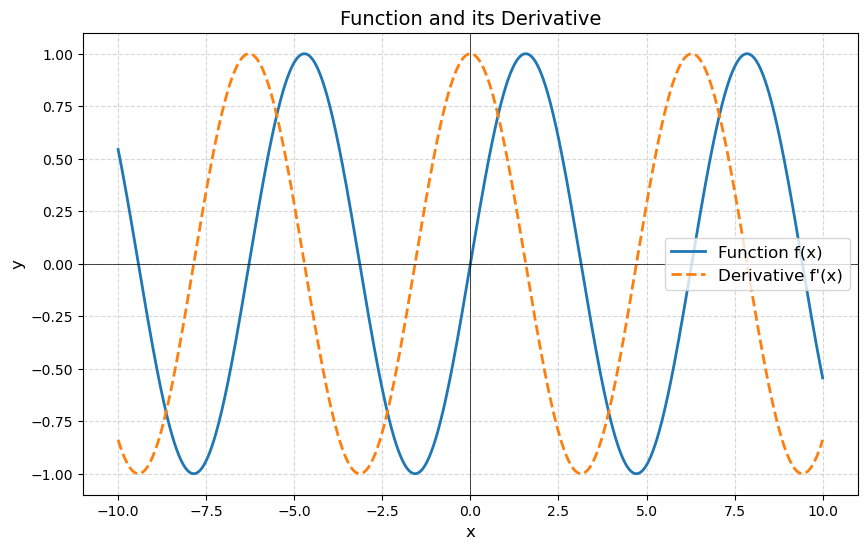

In [6]:
plot_derivative(np.sin)

These plots may look nice but they don't reflect the idea of **slope at a point** very well. Now that we're sure our functions are working, let's actually calculate the derivative at **one point** and see that it is, indeed, equal to the slope of the function at that point.

#### How to plot the tangent line?
We need to find the line equation first. 

We're given the derivative, which is equal to the slope of the line. In the line equation $y = ax + b$, the slope is $a$. We now have to find $b$. We're given a point $P(x_P; y_P)$ through which the line passes. Substitute $x_P$ and $y_P$:
$$ y_P = ax_P + b $$

$$ b = y_P - ax_P $$

Now that we have $a$ and $b$, we can plot the line given by $y = ax + b$. The parameter $b$ is sometimes called "y-intercept" (or "intercept").

Now we can copy the code from the previous function. This time, however, we won't plot the entire range, only one value of the derivative. We'll also show the point where we're calculating.

In [7]:
def plot_derivative_at_point(function, point, derivative = None, min_x = -10, max_x = 10):
    """
    Plots the function in the range [x_min; x_max]. Computes the tangent line to the function
    at the given point and also plots it
    """
    vectorized_function = np.vectorize(function)
    
    x = np.linspace(min_x, max_x, 1000)
    y = vectorized_function(x)
    
    slope = 0 # Slope of the tangent line
    if derivative is None:
        slope = calculate_derivative_at_point(function, point)
    else:
        slope = derivative(point)
    
    intercept = function(point) - slope * point
    tangent_line_x = np.linspace(point - 2, point + 2, 10)
    tangent_line_y = slope * tangent_line_x + intercept
    plt.plot(x, y)
    plt.plot(tangent_line_x, tangent_line_y)
    plt.show()

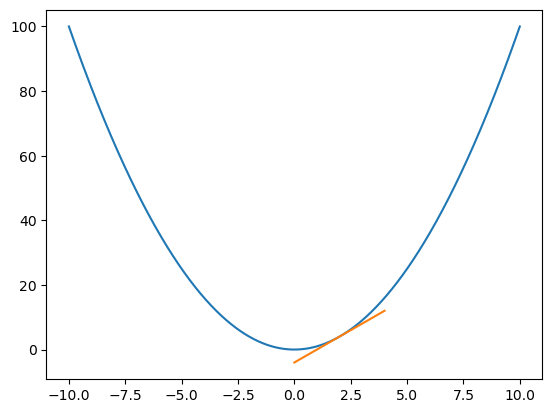

In [8]:
plot_derivative_at_point(lambda x: x ** 2, 2)

Looks like it! Let's zoom in to confirm:

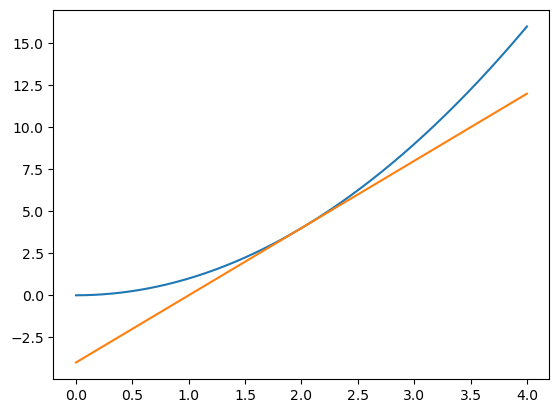

In [9]:
plot_derivative_at_point(lambda x: x ** 2, 2, min_x = 0, max_x = 4)

Let's also plot several tangents to the same function. Note that this will create many graphs by default. You can plot them all at once if you wish.

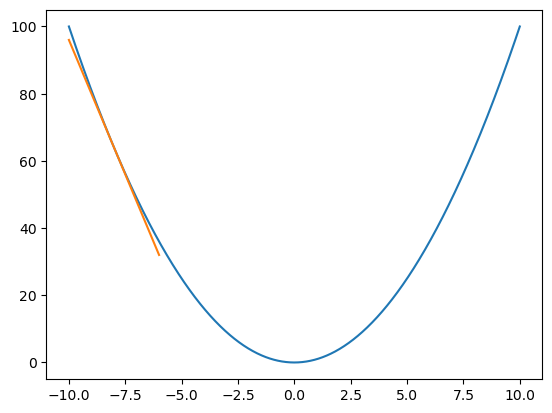

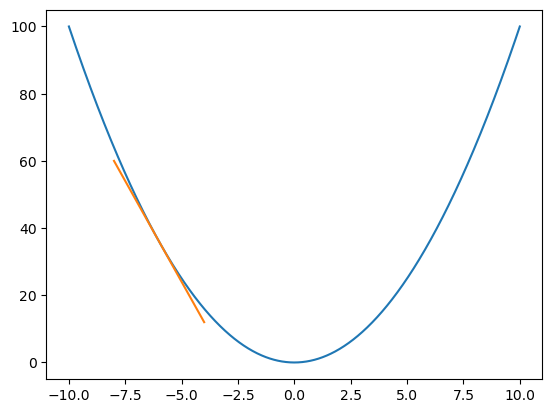

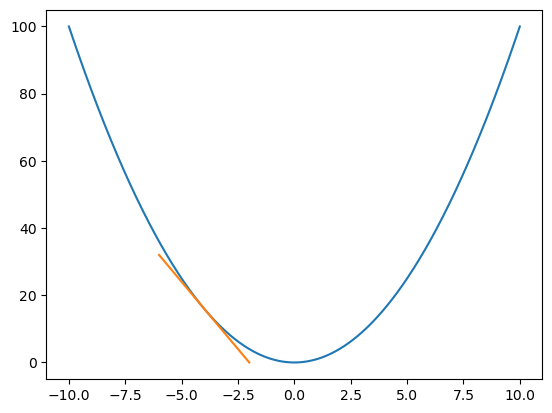

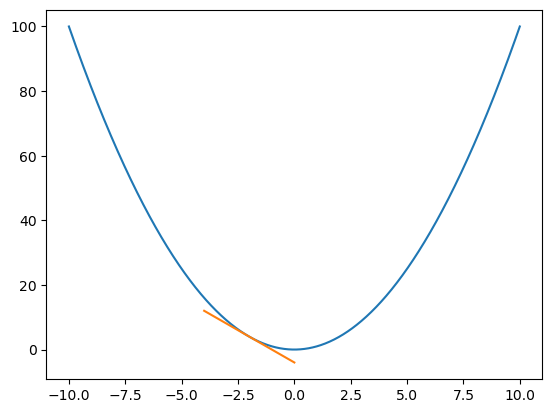

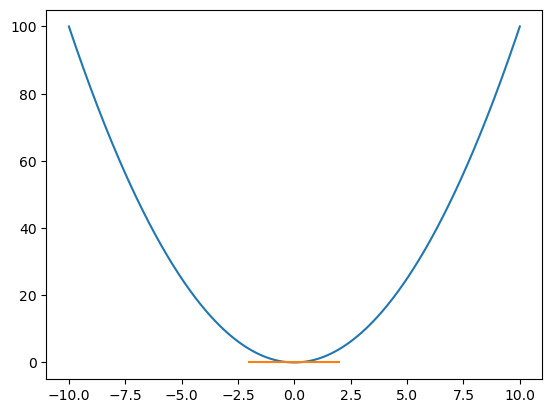

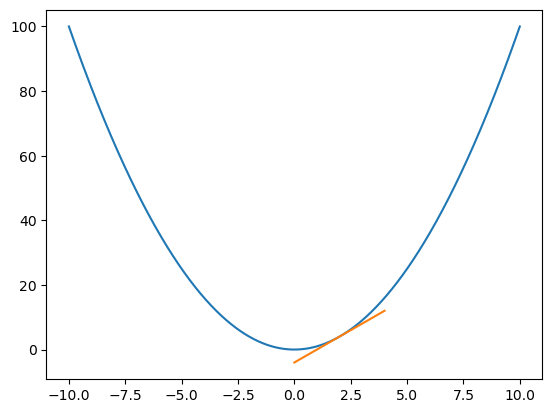

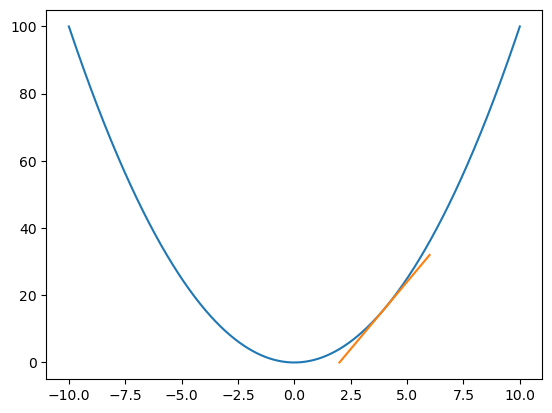

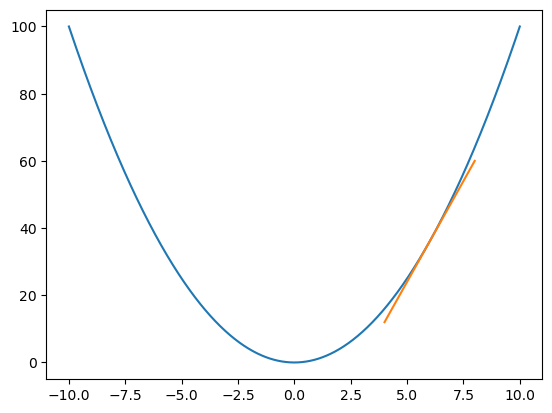

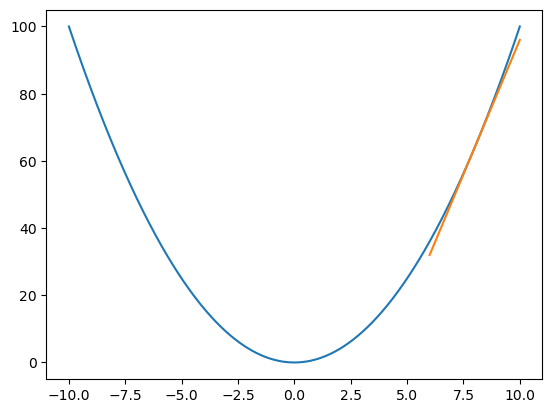

In [10]:
for x in np.arange(-8, 10, 2):
    plot_derivative_at_point(lambda x: x ** 2, x)

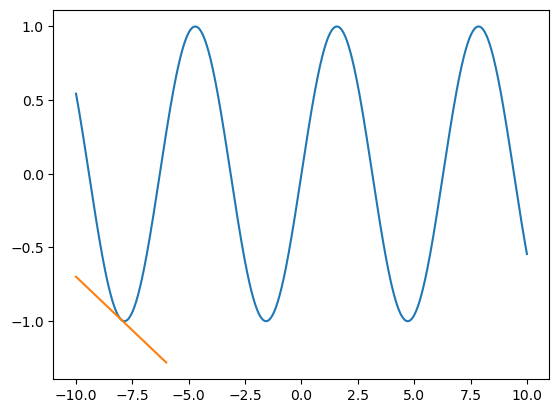

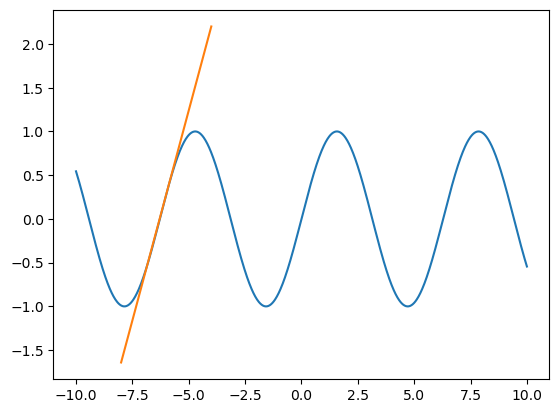

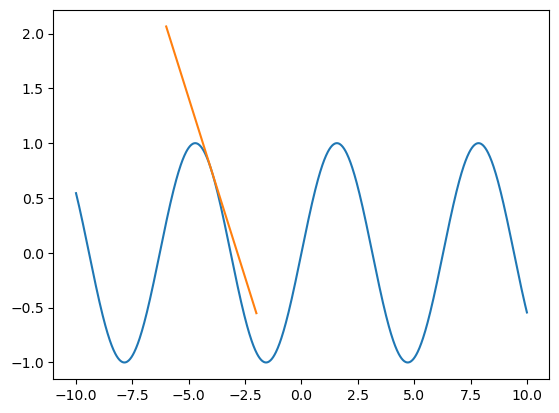

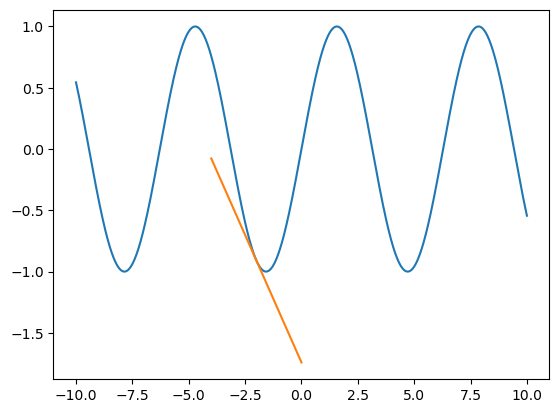

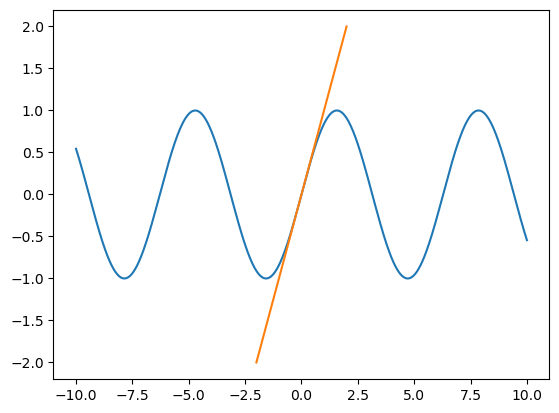

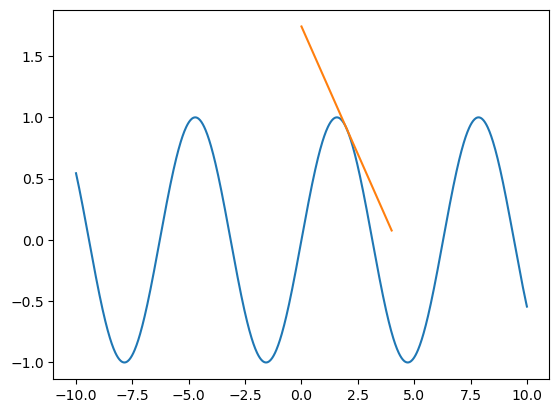

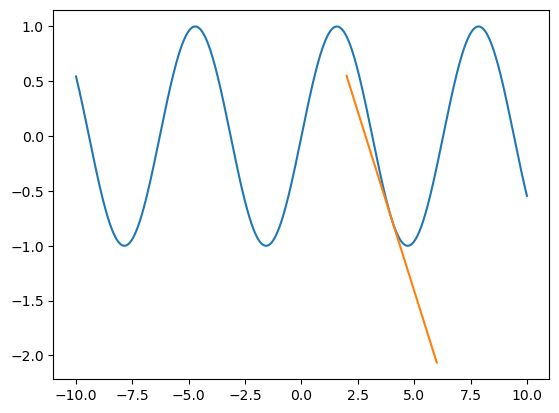

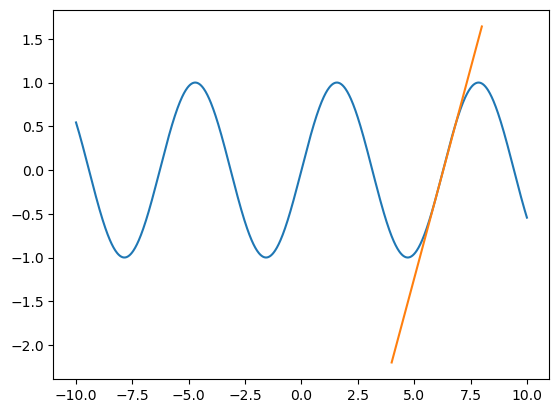

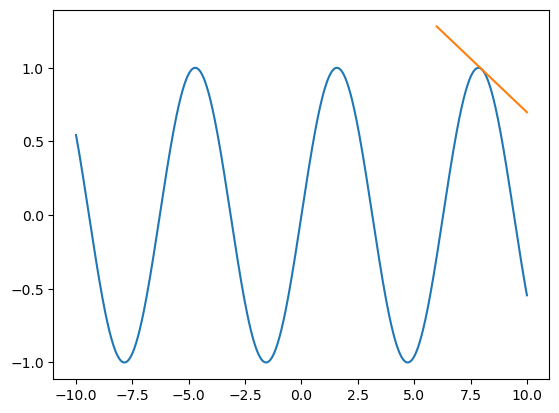

In [11]:
for x in np.arange(-8, 10, 2):
    plot_derivative_at_point(np.sin, x)

Now we have a visual proof that the derivative of a function at a given point is equal to the slope of the tangent line to the function.

### Problem 2. Limits. The Number $e$ as a Limit
We know what limits are, what they mean and how they relate to our tasks. Let's explore a special limit. This one arises from economics but we'll see it has applications throughout science because of its unique properties.

Imagine you're saving money in a bank. Every period, you accumulate [interest](https://en.wikipedia.org/wiki/Compound_interest) on your money. Let's say the bank is very generous and gives you **100% interest every year**.

How much money will you have after one year? Let's say you got $\$1$. After one year, you'll get your interest from the bank and you'll have $\$2$. Your money doubled, which was expected.

How about this offer: **50% interest every 6 months**? Will this be the same, better, or worse?
You start with $\$1$. After 6 months, you'll accumulate $50%$ interest to get $\$1,50$. After 6 more months, you'll get $50\%.1,50 = 0,75$, so your total is $2,25$. You got $\$0,25$ more!

Let's try to exploit the scheme and get rich.

**$100/12\%$ every month**
* January: $1 + 1/12$
* February: $(1 + 1/12) * (1 + 1/12)$
* March: $(1 + 1/12) * (1 + 1/12) * (1 + 1/12)$
* ...

We can see a pattern. Every period, we multiply our money by $1 + 1/12$. So, the final sum will be $$\$1.\left(1+\frac{1}{12}\right)^{12} = \$2,61$$

We did even better. This is always true. The more periods, the more money we accumulate. The more money we have, the more interest we accumulate. And that completes the vicious circle known as money saving :).

Let's try other options:

**$100/52\%$ every week**

$\$1.\left(1+\frac{1}{52}\right)^{52} = \$2,69$

**$100/31556926\%$ every second**

$\$1.\left(1+\frac{1}{31556926}\right)^{31556926} = \$2,718$

Well, there's a slight problem to our world domination plans. Even though we accumulate more and more money, we get *diminishing returns*. For 52 periods we got $2,69$, and for more than 3 million periods we only got like $\$0,02$ more. This pattern will continue.

Now we can ask ourselves, what is the maximum profit we can accumulate for a year? To do this, we can ask
$$ \lim_{n \ \rightarrow \infty}\left(1+\frac{1}{n}\right)^n = ? $$

It turns out this is a constant. It is approximately equal to $2,71828182\dots$. Since it's very useful, it's got a name: $e$, or Euler's number (sometimes called Napier's number). The limit above is **the definition of $e$**.

Why is it so useful? Let's go back to the original problem. In compound interest, the extra amount after every period is proportional to the amount at the start of the period. In other words, **the rate of change of a value is proportional to the value**. This pops out everywhere in nature and business. Some examples include radioactive decay (more atoms $\Rightarrow$ more decays), cooling down a cup of tea (the rate of cooling down depends on the temperature difference between the cup and the room), animal population models (more animals $\Rightarrow$ more babies), infection models, and so on.

To quickly verify the value of $e$, calculate the limit as we defined it above.

In [12]:
def calculate_limit_at_infinity(function):
    """
    Calculates a numerical approximation of the limit of the specified function
    as its parameter goes to infinity
    """
    n = 10 ** np.arange(0, 10)
    return zip(n, function(n))

In [13]:
limits = calculate_limit_at_infinity(lambda x: (1 + 1 / x) ** x)
for limit in limits:
    print(limit)

(1, 2.0)
(10, 2.5937424601000023)
(100, 2.7048138294215285)
(1000, 2.7169239322355936)
(10000, 2.7181459268249255)
(100000, 2.7182682371922975)
(1000000, 2.7182804690957534)
(10000000, 2.7182816941320818)
(100000000, 2.7182817983473577)
(1000000000, 2.7182820520115603)


### Problem 3. Derivatives of Exponential Functions
Use the function you defined in the first problem to plot the derivative of $y = 2^x$.

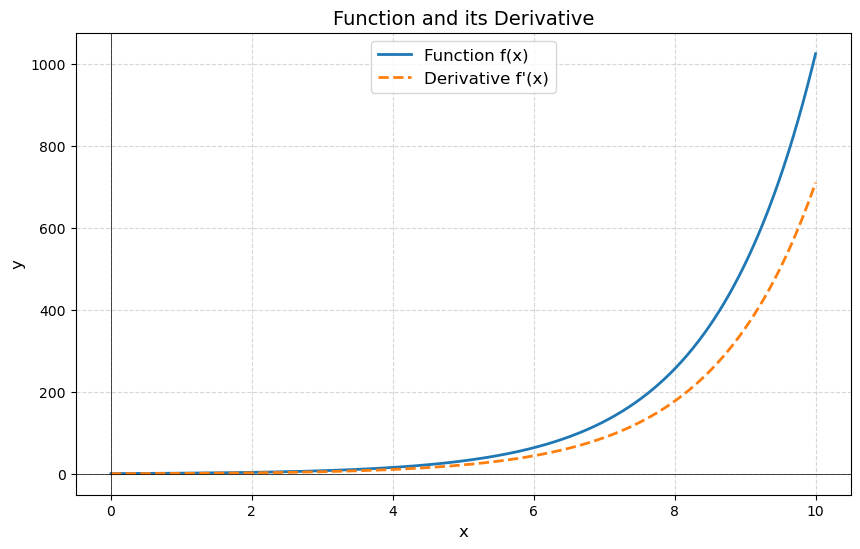

In [14]:
plot_derivative(lambda x: 2 ** x, min_x = 0, max_x = 10)

The function and its derivative look closely related, only the derivative seems to grow a bit slower than the function. Let's confirm that by looking at a broader range:

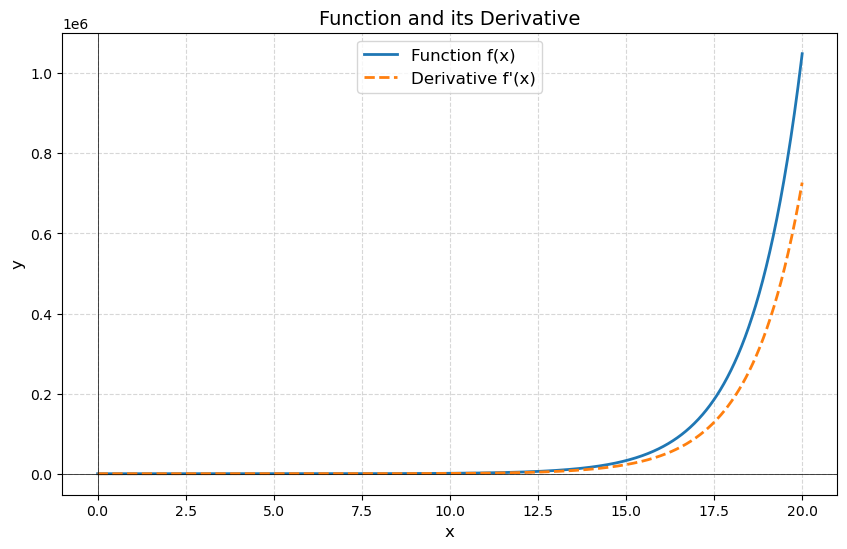

In [15]:
plot_derivative(lambda x: 2 ** x, min_x = 0, max_x = 20)

The same pattern will continue if we try to plot any exponential function, e.g. $y = 3^x$, $y = 4^x$ and so on, if the base of the exponent is greater than 1. If we want to plot, say, $y = 0,5^x$, we'll get a slightly different result. Note that the functions look more or less the same, only their signs are flipped.

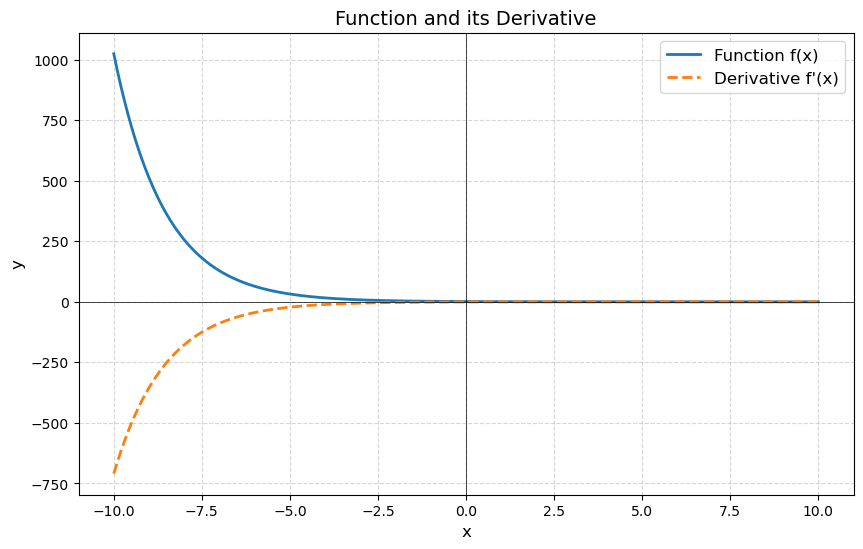

In [16]:
plot_derivative(lambda x: 0.5 ** x)

Very interesting things happen if we plot $y = e^x$:

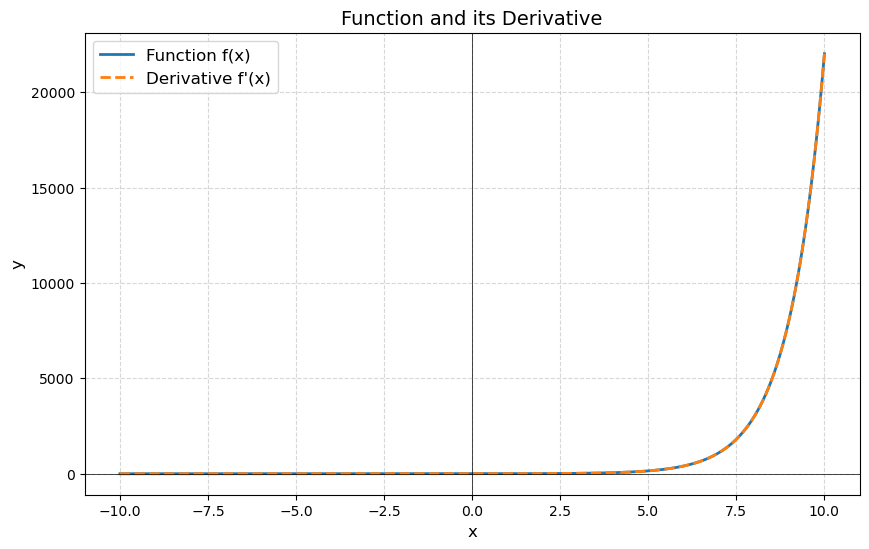

In [17]:
plot_derivative(np.exp)

The plots overlap. You can see that this is true if you plot the function and its derivative with different line widths. This means that

$$ (e^x)' = e^x $$

Also:
$$ (e^x)'' = e^x $$
$$ (e^x)''' = e^x $$
... and so on. This is the only function whose rate of change (derivative) is equal to the function itself. This property makes it even more interesting for science and math.

Also, do you remember that $e^{i\varphi} = \cos(\varphi) + i\sin(\varphi)$? This constant never ceases to amaze.

### Problem 4. Integrals and Area. Changing Variables in Integration
We know that the definition of an integral is the area "between" the function we're integrating, and the x-axis. This gives us a method to calculate integrals. Most integrals can't be solved analytically but have numerical solutions. One such integral is 
$$\int\sin(x^2)dx$$

Note that we can only solve **definite integrals** numerically.

The simplest way to calculate the integral is to apply the definition, like in the case of the derivative. This is called [the trapezoid method](http://www.mathwords.com/t/trapezoid_rule.htm) because the area is approximated as a series of trapezoids.

Write a function which does exactly that. Use `numpy` and vectorization as much as possible.

In [18]:
def calculate_integral(function, x_min, x_max, num_points = 5000):
    """
    Calculates a numerical approximation of the definite integral of the provided function
    between the points x_min and x_max.
    The parameter n specifies the number of points at which the integral will be calculated
    """
    # Create evenly spaced points between x_min and x_max
    x = np.linspace(x_min, x_max, num_points)
    
    # Calculate function values at these points
    y = np.vectorize(function)(x)
    
    # Calculate the width of each trapezoid
    dx = (x_max - x_min) / (num_points - 1)
    
    # Apply trapezoid rule: sum of (f(x_i) + f(x_{i+1})) * dx/2
    integral = dx * (np.sum(y) - (y[0] + y[-1])/2)
    
    return integral

In [19]:
print(calculate_integral(lambda x: x ** 2, 0, 1)) # Should be close to 0.333
print(calculate_integral(lambda x: np.sin(x ** 2), 0, 5)) # Should be close to 0.528

0.33333334000266746
0.5279181074995319


Let's apply our insight to finding the area of a circle. We know the equation of a circle is not a function (it's more like two functions). We can, however be clever. One way is to integrate both of the functions and add them together. Another way is to integrate one and double the area. 

**Note:** We're trying to find the total area of the circle, there is **no negative area** in this particular case.

Another, even more clever way is to look at a quarter of the circle. This is convenient because we may look at the quadrant where $x > 0$ and $y > 0$. So, we'll need to find the area between:
1. $x \ge 0$
2. $y \ge 0$
3. The circle $x^2 + y^2 \le R^2$ (let's fix the radius to be 1)

$\Rightarrow y = \sqrt{R^2 - x^2} = \sqrt{1 - x^2}$

After all of this, we'll need to multiply the result by 4.

$$ S = 4 \int_0^1\sqrt{1 - x^2}dx $$

In [20]:
circle_piece_area = calculate_integral(lambda x: np.sqrt(1 - x ** 2), 0, 1)
total_area = 4 * circle_piece_area
print(total_area)

3.1415893264324883


And we got a value close to $\pi$, which is the real answer.

#### * Optional: Integration in polar coordinates
We can, however, do better. We know that a circle looks much simpler in polar coordinates. Let's now change our viewpoint.

In polar coordinates $(r, \varphi)$, the equation of a circle is

$$ r = R $$

which is our case simplifies to $r = 1$. Note there's no dependence on $\theta$: the radius is the same regardless of the angle. The boundaries for $\theta$ are every possible angle from $0$ to $2\pi$ radians. For $r$, we have $r \ge 0$ and $r \le R$. This translates to the integral:

$$ S = \int_{\theta=0}^{2\pi}\int_{r=0}^R r dr d\theta $$

**Note:** We usually don't write the variables at the bottom of the integral symbol. I've done this just for clarity.

I won't go into details but since there's no dependence on $\theta$, we can simply "separate the integrals" and multiply 
them.

$$ S = \int_{0}^{2\pi}d\theta .\int_{r=0}^R r dr $$

The first one is:
$$ I_1 = \int_0^R r dr = \left.\frac{r^2}{2}\right|_{0}^{R} = \frac{R^2}{2} - \frac{0^2}{2} = \frac{R^2}{2} $$

And the second one is:
$$ I_2 = \int_0^{2\pi}1d\theta = \left.\theta\right|_0^{2\pi} = 2\pi - 0 = 2\pi $$

$$ \Rightarrow  S = I_1I_2 = 2\pi\frac{R^2}{2} = \pi R^2$$

$$ S = \pi R^2$$

### * Problem 5. Taylor Series. Computing Function Value Approximations
Some functions can be really hard to compute, or even impossible. However, there are ways to approximate functions with other functions, which are simpler. The idea is the same as what we already used: we approximated the function with its tangent line to find the derivative at a given point. Research what Taylor series are and how they're used in approximating functions. Derive and implement the Taylor expansions of several functions.
* What is "function approximation"?
* Why can't we compute all functions numerically?
* What are some easy ways to approximate a function near a given point?
* Polynomial functions are very useful approximators. Why? Think about their continuity and derivatives
* What information does the first derivative of a function give us?
    * How does that information generalize to higher-order derivatives (second, third, fourth, etc.)?
* What are Taylor series? Why does it work?
* Derive some Taylor series expansions. Some common functions are $\sin(x)$ and $\cos(x)$
    * To work with infinite sums, we have to "cut" them somewhere. Why are we allowed to do that? Think about the different terms: one Taylor expansion term doesn't affect the others
    * How are those expansions used in calculators / numerical libraries?
    * Write the code that computes the approximations
    * Test the code
* How many terms do we need?
    * Visualize how the approximation is getting better as we include more terms in the Taylor expansion

    

# Taylor Series and Function Approximation

## What is Function Approximation?

Function approximation is the technique of using simpler functions to estimate or approximate more complex functions. This is especially valuable when:
- A function is difficult or impossible to compute directly
- We need faster computation than the original function allows
- We need to understand a function's behavior in a specific region

## Why Can't We Compute All Functions Numerically?

Some functions are challenging to compute numerically because:
- They may involve complex operations like integrals without closed-form solutions
- They may require infinite operations (e.g., infinite series)
- Some functions have singularities or discontinuities
- Computational limitations like precision and rounding errors affect accuracy
- Certain transcendental functions require approximation methods

## Approximating Functions Near a Point

The simplest way to approximate a function near a point is through linear approximation using the tangent line:

If we have a function f(x) at point a:
- The tangent line approximation is: f(x) ≈ f(a) + f'(a)(x-a)
- This gives reasonably accurate results when x is close to a

## Polynomial Functions as Approximators

Polynomials make excellent approximators because:
- They're easy to compute (just addition, multiplication, and exponentiation)
- They have continuous derivatives of all orders
- Their behaviors are well-understood and predictable
- They can be differentiated and integrated term by term
- As we increase the degree, they can approximate increasingly complex functions

## Information from Derivatives

The first derivative f'(x) tells us:
- The rate of change of the function
- The slope of the tangent line at any point
- Direction of increase/decrease of the function

Higher-order derivatives provide increasingly detailed information:
- Second derivative (f''(x)): Rate of change of the slope, concavity
- Third derivative (f'''(x)): Rate of change of concavity
- Fourth and higher: More subtle aspects of the function's behavior

## Taylor Series

Taylor series allow us to approximate a function around a point 'a' using polynomial terms that match the function's value and derivatives at that point.

### Derivation of Taylor Series Formula

For a function f(x) that's infinitely differentiable at point a:

1. We want a polynomial P(x) such that P(a) = f(a), P'(a) = f'(a), P''(a) = f''(a), etc.
2. Let's try a polynomial: P(x) = c₀ + c₁(x-a) + c₂(x-a)² + c₃(x-a)³ + ...
3. At x = a: P(a) = c₀ = f(a)
4. Take the derivative: P'(x) = c₁ + 2c₂(x-a) + 3c₃(x-a)² + ...
5. At x = a: P'(a) = c₁ = f'(a)
6. Take second derivative: P''(x) = 2c₂ + 6c₃(x-a) + ...
7. At x = a: P''(a) = 2c₂ → c₂ = f''(a)/2!

Continuing this pattern, we find: cₙ = f^(n)(a)/n!

Therefore, the Taylor series is:
f(x) = f(a) + f'(a)(x-a) + f''(a)(x-a)²/2! + f'''(a)(x-a)³/3! + ...

Or more compactly:
f(x) = $\sum_{n=0}^{\infty} \frac{f^{(n)}(a)}{n!}(x-a)^n$

### Maclaurin Series

A Maclaurin series is simply a Taylor series centered at a = 0:
f(x) = f(0) + f'(0)x + f''(0)x²/2! + f'''(0)x³/3! + ...

## Common Taylor Series Expansions

### Taylor Series for sin(x) around x = 0

Let f(x) = sin(x), and a = 0:
- f(0) = sin(0) = 0
- f'(x) = cos(x) → f'(0) = cos(0) = 1
- f''(x) = -sin(x) → f''(0) = -sin(0) = 0
- f'''(x) = -cos(x) → f'''(0) = -cos(0) = -1
- f⁽⁴⁾(x) = sin(x) → f⁽⁴⁾(0) = sin(0) = 0

This pattern repeats every 4 derivatives, so:
sin(x) = x - x³/3! + x⁵/5! - x⁷/7! + ...

Or more compactly:
sin(x) = $\sum_{n=0}^{\infty} \frac{(-1)^n \cdot x^{2n+1}}{(2n+1)!}$

### Taylor Series for cos(x) around x = 0

Let f(x) = cos(x), and a = 0:
- f(0) = cos(0) = 1
- f'(x) = -sin(x) → f'(0) = -sin(0) = 0
- f''(x) = -cos(x) → f''(0) = -cos(0) = -1
- f'''(x) = sin(x) → f'''(0) = sin(0) = 0
- f⁽⁴⁾(x) = cos(x) → f⁽⁴⁾(0) = cos(0) = 1

This gives us:
cos(x) = 1 - x²/2! + x⁴/4! - x⁶/6! + ...

Or more compactly:
cos(x) = $\sum_{n=0}^{\infty} \frac{(-1)^n \cdot x^{2n}}{(2n)!}$

## Truncating Infinite Series

We can truncate Taylor series (take a finite number of terms) because:
- Later terms become increasingly small for x values near the expansion point
- The error (remainder) can be bounded mathematically
- For many functions, we can achieve desired precision with a reasonable number of terms

## How Many Terms Do We Need?

The number of terms needed depends on:

1. **Desired accuracy**: More terms generally means better accuracy
2. **Range of x values**: Approximations work best near the expansion point
3. **Function characteristics**: Some functions converge faster than others

From our visualization, you can see:
- With just 1 term, we get a linear approximation
- With 3 terms, sine and cosine are already reasonably accurate near x = 0
- With 10 terms, the approximation is excellent within [-π, π]
- The error decreases exponentially as we add more terms

## Usage in Calculators and Numerical Libraries

Taylor series are fundamental to numerical computing:
- Scientific calculators use these approximations to compute functions
- Libraries like numpy and scipy implement optimized versions of these expansions
- Often, they use specialized algorithms that reduce computation while maintaining accuracy
- Range reduction techniques are applied (e.g., trig identities) to keep inputs within optimal ranges

## Conclusion

Taylor series provide a powerful tool for approximating complex functions with simple polynomials. By matching the function's derivatives at a specific point, we can create increasingly accurate approximations by adding more terms. This technique is essential in numerical computing, allowing us to calculate values for functions that would otherwise be difficult or impossible to compute directly.



## Code for Computing Approximations

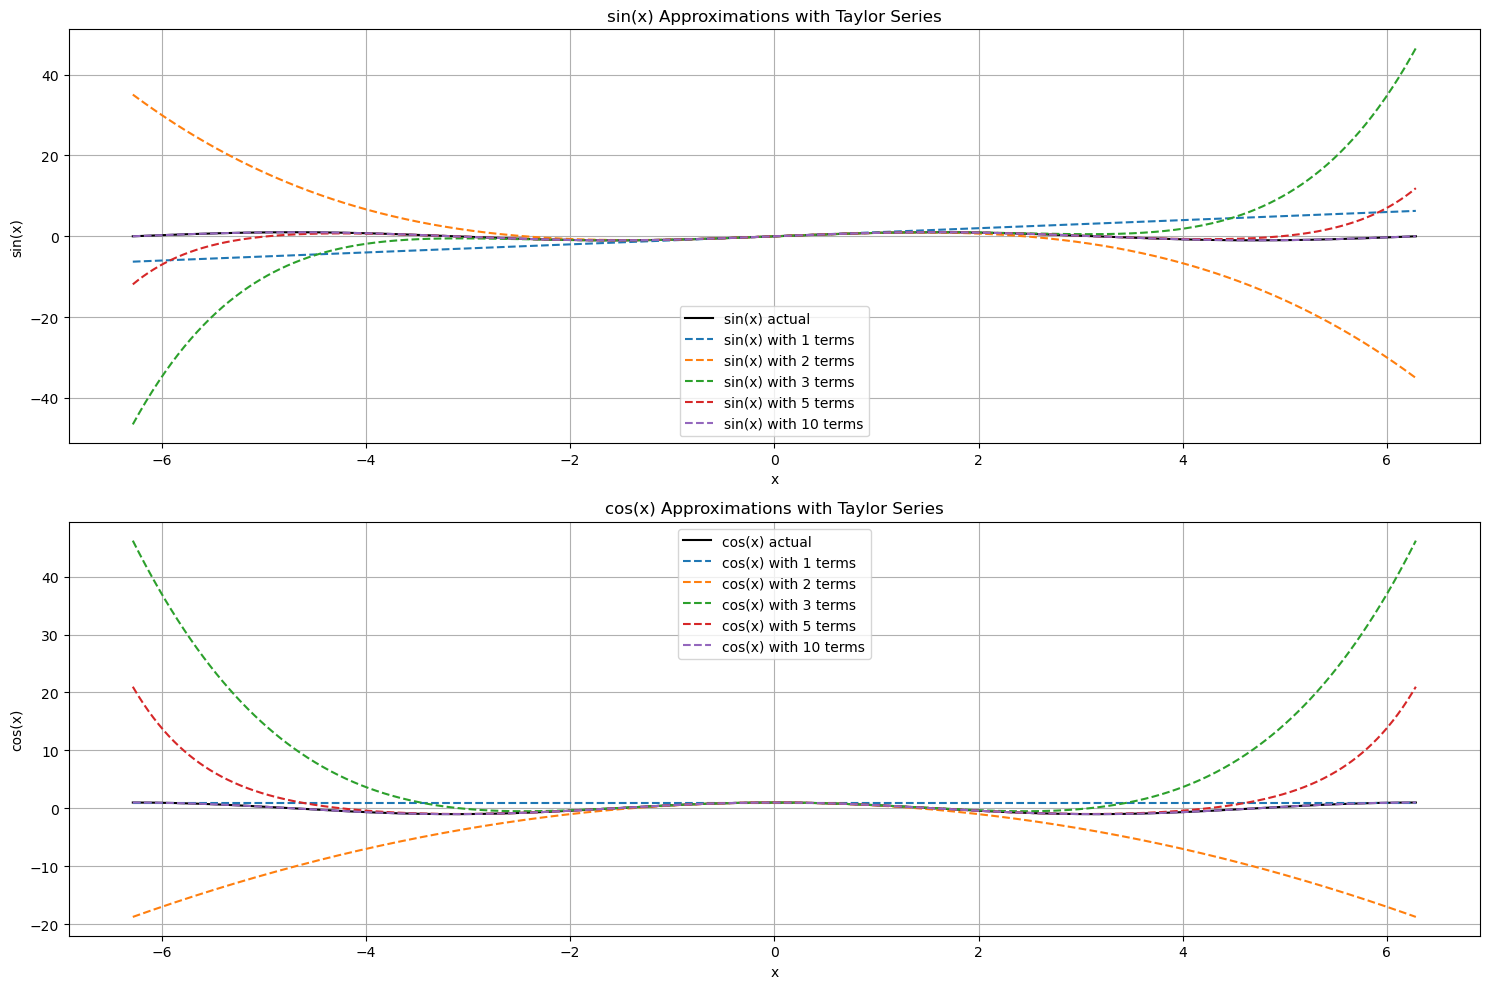

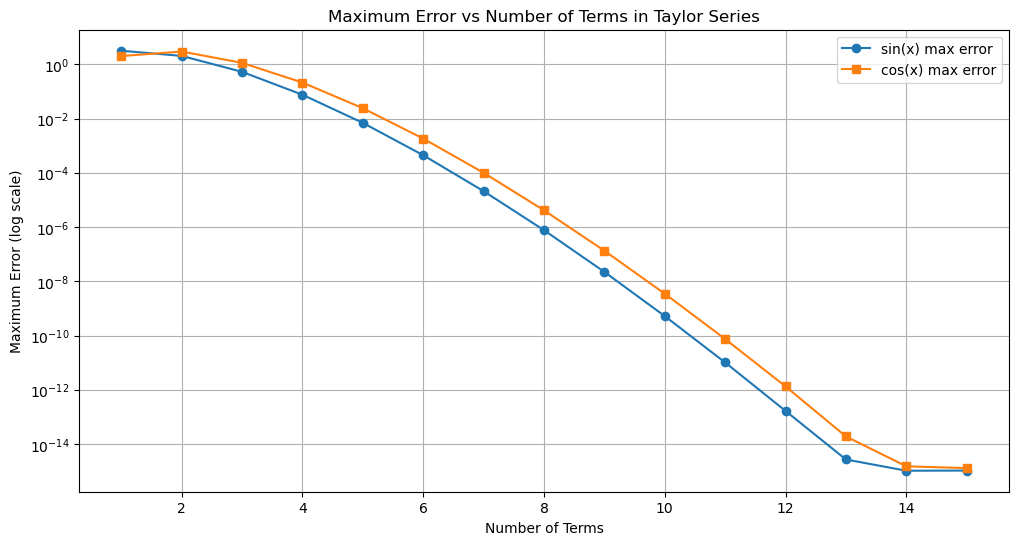

In [21]:
def factorial(n):
    """Calculate factorial of n"""
    if n == 0 or n == 1:
        return 1
    return n * factorial(n-1)

def sin_taylor(x, terms=10):
    """Approximate sin(x) using Taylor series with specified number of terms"""
    result = 0
    for n in range(terms):
        # Only odd terms appear in sin(x) expansion
        term_index = 2*n + 1
        coefficient = (-1)**n / factorial(term_index)
        result += coefficient * (x**term_index)
    return result

def cos_taylor(x, terms=10):
    """Approximate cos(x) using Taylor series with specified number of terms"""
    result = 0
    for n in range(terms):
        # Only even terms appear in cos(x) expansion
        term_index = 2*n
        coefficient = (-1)**n / factorial(term_index)
        result += coefficient * (x**term_index)
    return result

# Test the functions
x_values = np.linspace(-2*np.pi, 2*np.pi, 1000)
sin_actual = np.sin(x_values)
cos_actual = np.cos(x_values)

# Compare approximations with different numbers of terms
plt.figure(figsize=(15, 10))

# Plot sin(x) approximations
plt.subplot(2, 1, 1)
plt.plot(x_values, sin_actual, 'k-', label='sin(x) actual')

for terms in [1, 2, 3, 5, 10]:
    sin_approx = [sin_taylor(x, terms) for x in x_values]
    plt.plot(x_values, sin_approx, '--', label=f'sin(x) with {terms} terms')

plt.title('sin(x) Approximations with Taylor Series')
plt.legend()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('sin(x)')

# Plot cos(x) approximations
plt.subplot(2, 1, 2)
plt.plot(x_values, cos_actual, 'k-', label='cos(x) actual')

for terms in [1, 2, 3, 5, 10]:
    cos_approx = [cos_taylor(x, terms) for x in x_values]
    plt.plot(x_values, cos_approx, '--', label=f'cos(x) with {terms} terms')

plt.title('cos(x) Approximations with Taylor Series')
plt.legend()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('cos(x)')

plt.tight_layout()
plt.show()

# Calculate error for different numbers of terms
def calculate_error(x_range, actual_func, approx_func, terms_list):
    errors = []
    for terms in terms_list:
        max_error = 0
        for x in x_range:
            error = abs(actual_func(x) - approx_func(x, terms))
            max_error = max(max_error, error)
        errors.append(max_error)
    return errors

# Evaluate error for sin(x)
x_test = np.linspace(-np.pi, np.pi, 1000)  # Test within [-π, π]
terms_list = range(1, 16)  # Test 1 to 15 terms

sin_errors = calculate_error(x_test, np.sin, sin_taylor, terms_list)
cos_errors = calculate_error(x_test, np.cos, cos_taylor, terms_list)

# Plot error vs number of terms
plt.figure(figsize=(12, 6))
plt.semilogy(terms_list, sin_errors, 'o-', label='sin(x) max error')
plt.semilogy(terms_list, cos_errors, 's-', label='cos(x) max error')
plt.title('Maximum Error vs Number of Terms in Taylor Series')
plt.xlabel('Number of Terms')
plt.ylabel('Maximum Error (log scale)')
plt.grid(True)
plt.legend()
plt.show()

### ** 6. Calculus in Medical Data. Electrocardiography (EKG)
EKG data is basically a 1-dimensional function of time. It records electrical impulses which depend on the state of the heart. How can we analyze EKG data?
* What is EKG data? What is the physical process and what is its interpretation?
    * Provide several EKG plots
    * What are the main parts of an EKG?
* How does the concept of local extrema relate to EKG?
* How does the concept of "convex" / "concave" graphs relate to EKG?

You can take various paths witk EKG data. Some companies, Samsung for example, use a heart rate sensor to measure stress and blood oxygen levels. An algorithm takes data for several seconds or minutes and analyzes it in several ways.
* Optional: Research how you can use EKG or pulse sensor data to measure oxygen in the blood. Have a look [here](https://www.quora.com/How-do-optical-heart-rate-sensors-work) for example
* Optional: How can you use the pulse sensor data to measure stress levels? There are many approaches to this one.
* Optional: Many diseases can be diagnosed from EKG data. Can you train an algorithm to recognize a certain disease? This is related to *time series* analysis

# Calculus in Medical Data: Electrocardiography (EKG)

## What is EKG Data?

An electrocardiograph (EKG or ECG) is a recording of the electrical activity of the heart over time. It works by detecting and amplifying the tiny electrical changes on the skin that are caused by the heart muscle's electrophysiologic pattern of depolarizing and repolarizing during each heartbeat.

### Physical Process
1. **Cardiac electrical system**: The heart has specialized cells that generate electrical impulses
2. **Conduction pathway**: These impulses follow a specific path through the heart
3. **Electrode detection**: Surface electrodes placed on the skin detect these electrical signals
4. **Amplification and recording**: The signals are amplified and recorded as voltage changes over time

### Clinical Interpretation
EKG data provides crucial information about:
- Heart rate and rhythm
- Heart chamber size and position
- Evidence of damage to heart tissues
- Effects of cardiac drugs
- Function of implanted pacemakers


## EKG Plots and Main Components

Let's first import necessary libraries and create some sample EKG data for visualization:

In [23]:
# Set style for better visualization
plt.style.use('ggplot')

Now, let's create a function to generate a synthetic normal EKG signal:

In [24]:
def generate_ecg(duration=10, fs=250):
    """
    Generate a synthetic ECG signal
    
    Parameters:
    duration (float): Duration of the signal in seconds
    fs (int): Sampling frequency in Hz
    
    Returns:
    tuple: (time array, ECG signal)
    """
    t = np.arange(0, duration, 1.0/fs)
    
    # Heart rate: 60-80 bpm (normal)
    hr = 70
    
    # Generate ECG components
    # P wave: small rounded wave
    # QRS complex: sharp peak (dominant R wave)
    # T wave: rounded wave after QRS
    
    ecg = np.zeros_like(t)
    
    # Time for one heartbeat
    period = 60.0 / hr
    
    # Generate each heartbeat
    for i in np.arange(0, duration, period):
        # Find indices for this heartbeat
        idx = np.logical_and(t >= i, t <= i + period)
        beat_t = t[idx] - i
        
        # P wave (atrial depolarization)
        p_center = 0.2
        p_width = 0.08
        p_height = 0.25
        p_wave = p_height * np.exp(-((beat_t - p_center) ** 2) / (2 * p_width ** 2))
        
        # QRS complex (ventricular depolarization)
        # Q wave (small negative)
        q_center = 0.4
        q_width = 0.02
        q_height = -0.1
        q_wave = q_height * np.exp(-((beat_t - q_center) ** 2) / (2 * q_width ** 2))
        
        # R wave (large positive)
        r_center = 0.45
        r_width = 0.04
        r_height = 1.0
        r_wave = r_height * np.exp(-((beat_t - r_center) ** 2) / (2 * r_width ** 2))
        
        # S wave (negative after R)
        s_center = 0.5
        s_width = 0.02
        s_height = -0.2
        s_wave = s_height * np.exp(-((beat_t - s_center) ** 2) / (2 * s_width ** 2))
        
        # T wave (ventricular repolarization)
        t_center = 0.7
        t_width = 0.1
        t_height = 0.35
        t_wave = t_height * np.exp(-((beat_t - t_center) ** 2) / (2 * t_width ** 2))
        
        # Sum all components
        beat = p_wave + q_wave + r_wave + s_wave + t_wave
        
        # Add to ECG signal
        ecg[idx] += beat
    
    # Add some noise
    noise = np.random.normal(0, 0.03, size=len(t))
    ecg += noise
    
    return t, ecg

Let's generate and plot a normal EKG signal:

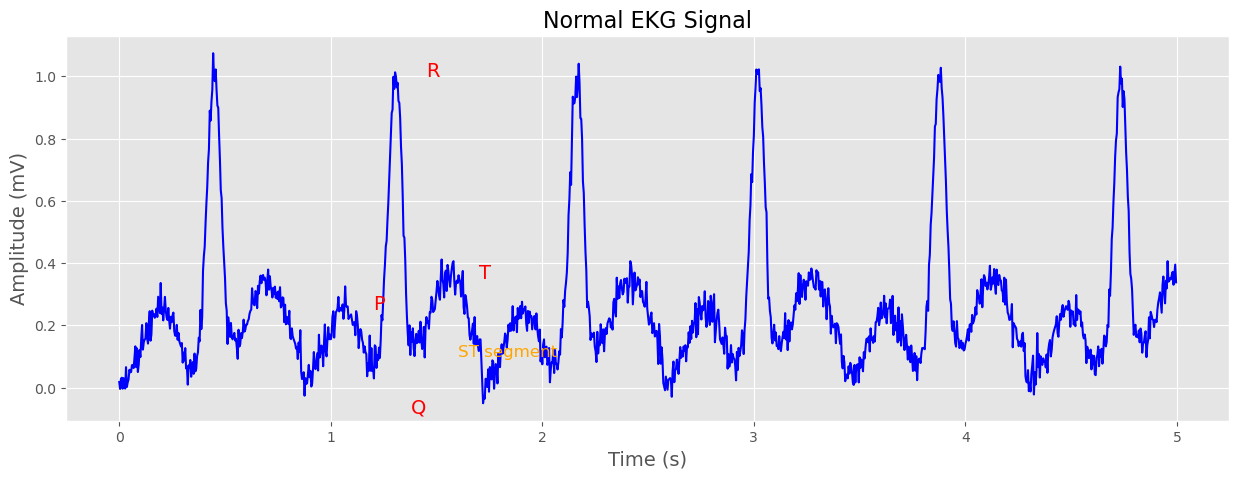

In [25]:
# Generate a normal ECG signal
time, ecg_normal = generate_ecg(duration=5)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(time, ecg_normal, 'b-')
plt.title('Normal EKG Signal', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude (mV)', fontsize=14)
plt.grid(True)

# Add markers for major components (for one beat)
beat_start = 1.0
plt.annotate('P', xy=(beat_start + 0.2, 0.25), fontsize=14, color='red')
plt.annotate('Q', xy=(beat_start + 0.38, -0.08), fontsize=14, color='red')
plt.annotate('R', xy=(beat_start + 0.45, 1.0), fontsize=14, color='red')
plt.annotate('S', xy=(beat_start + 0.5, -0.18), fontsize=14, color='red')
plt.annotate('T', xy=(beat_start + 0.7, 0.35), fontsize=14, color='red')

# Add intervals and segments for one beat
plt.annotate('PR interval', xy=(beat_start + 0.3, -0.3), fontsize=12, color='green')
plt.annotate('QRS complex', xy=(beat_start + 0.45, -0.4), fontsize=12, color='purple')
plt.annotate('ST segment', xy=(beat_start + 0.6, 0.1), fontsize=12, color='orange')
plt.annotate('QT interval', xy=(beat_start + 0.55, -0.5), fontsize=12, color='blue')

plt.show()

Now, let's create functions to generate abnormal EKG signals:

In [26]:
def generate_tachycardia_ecg(duration=10, fs=250):
    """Generate synthetic tachycardia EKG (fast heart rate)"""
    # Similar to normal EKG but with faster heart rate
    t = np.arange(0, duration, 1.0/fs)
    
    # Tachycardia: >100 bpm
    hr = 120
    
    # Use the same generation logic as normal EKG
    period = 60.0 / hr
    ecg = np.zeros_like(t)
    
    for i in np.arange(0, duration, period):
        idx = np.logical_and(t >= i, t <= i + period)
        beat_t = t[idx] - i
        
        p_wave = 0.25 * np.exp(-((beat_t - 0.2) ** 2) / (2 * 0.08 ** 2))
        q_wave = -0.1 * np.exp(-((beat_t - 0.4) ** 2) / (2 * 0.02 ** 2))
        r_wave = 1.0 * np.exp(-((beat_t - 0.45) ** 2) / (2 * 0.04 ** 2))
        s_wave = -0.2 * np.exp(-((beat_t - 0.5) ** 2) / (2 * 0.02 ** 2))
        t_wave = 0.35 * np.exp(-((beat_t - 0.7) ** 2) / (2 * 0.1 ** 2))
        
        beat = p_wave + q_wave + r_wave + s_wave + t_wave
        ecg[idx] += beat
    
    noise = np.random.normal(0, 0.03, size=len(t))
    ecg += noise
    
    return t, ecg

def generate_st_elevation_ecg(duration=10, fs=250):
    """Generate synthetic EKG with ST elevation (myocardial infarction sign)"""
    t = np.arange(0, duration, 1.0/fs)
    
    hr = 75
    period = 60.0 / hr
    ecg = np.zeros_like(t)
    
    for i in np.arange(0, duration, period):
        idx = np.logical_and(t >= i, t <= i + period)
        beat_t = t[idx] - i
        
        p_wave = 0.25 * np.exp(-((beat_t - 0.2) ** 2) / (2 * 0.08 ** 2))
        q_wave = -0.1 * np.exp(-((beat_t - 0.4) ** 2) / (2 * 0.02 ** 2))
        r_wave = 1.0 * np.exp(-((beat_t - 0.45) ** 2) / (2 * 0.04 ** 2))
        s_wave = -0.2 * np.exp(-((beat_t - 0.5) ** 2) / (2 * 0.02 ** 2))
        
        # ST elevation - higher T wave and elevated segment
        st_elevation = 0.2 * np.logical_and(beat_t > 0.5, beat_t < 0.7)
        t_wave = 0.45 * np.exp(-((beat_t - 0.7) ** 2) / (2 * 0.1 ** 2))
        
        beat = p_wave + q_wave + r_wave + s_wave + st_elevation + t_wave
        ecg[idx] += beat
    
    noise = np.random.normal(0, 0.03, size=len(t))
    ecg += noise
    
    return t, ecg

def generate_afib_ecg(duration=10, fs=250):
    """Generate synthetic atrial fibrillation EKG (irregular rhythm, no P waves)"""
    t = np.arange(0, duration, 1.0/fs)
    ecg = np.zeros_like(t)
    
    # Irregular intervals for AFib
    # Base heart rate around 100 bpm but with variability
    base_period = 60.0 / 100
    
    # Generate irregular beat timings
    beat_times = []
    current_time = 0
    while current_time < duration:
        # Add variability to beat timing (±30%)
        variability = base_period * (0.7 + 0.6 * np.random.random())
        current_time += variability
        if current_time < duration:
            beat_times.append(current_time)
    
    # Generate each irregular beat
    for beat_time in beat_times:
        # Find indices for this heartbeat
        start_idx = int(beat_time * fs)
        end_idx = min(int((beat_time + base_period) * fs), len(t))
        idx = np.arange(start_idx, end_idx)
        if len(idx) == 0:
            continue
            
        beat_t = t[idx] - beat_time
        
        # No P wave in AFib
        # Irregular QRS complex
        q_wave = -0.1 * np.exp(-((beat_t - 0.1) ** 2) / (2 * 0.02 ** 2))
        r_wave = 0.8 * np.exp(-((beat_t - 0.15) ** 2) / (2 * 0.04 ** 2))
        s_wave = -0.2 * np.exp(-((beat_t - 0.2) ** 2) / (2 * 0.02 ** 2))
        t_wave = 0.3 * np.exp(-((beat_t - 0.4) ** 2) / (2 * 0.1 ** 2))
        
        beat = q_wave + r_wave + s_wave + t_wave
        
        # Add beat to ECG signal
        for j, idx_val in enumerate(idx):
            if idx_val < len(ecg):
                ecg[idx_val] += beat[j] if j < len(beat) else 0
    
    # Add fibrillatory waves (rapid, irregular atrial activity)
    fibrillatory_waves = 0.1 * np.sin(2 * np.pi * 8 * t) + 0.08 * np.sin(2 * np.pi * 12 * t)
    ecg += fibrillatory_waves
    
    # Add noise
    noise = np.random.normal(0, 0.05, size=len(t))
    ecg += noise
    
    return t, ecg

Let's plot different types of EKG signals:

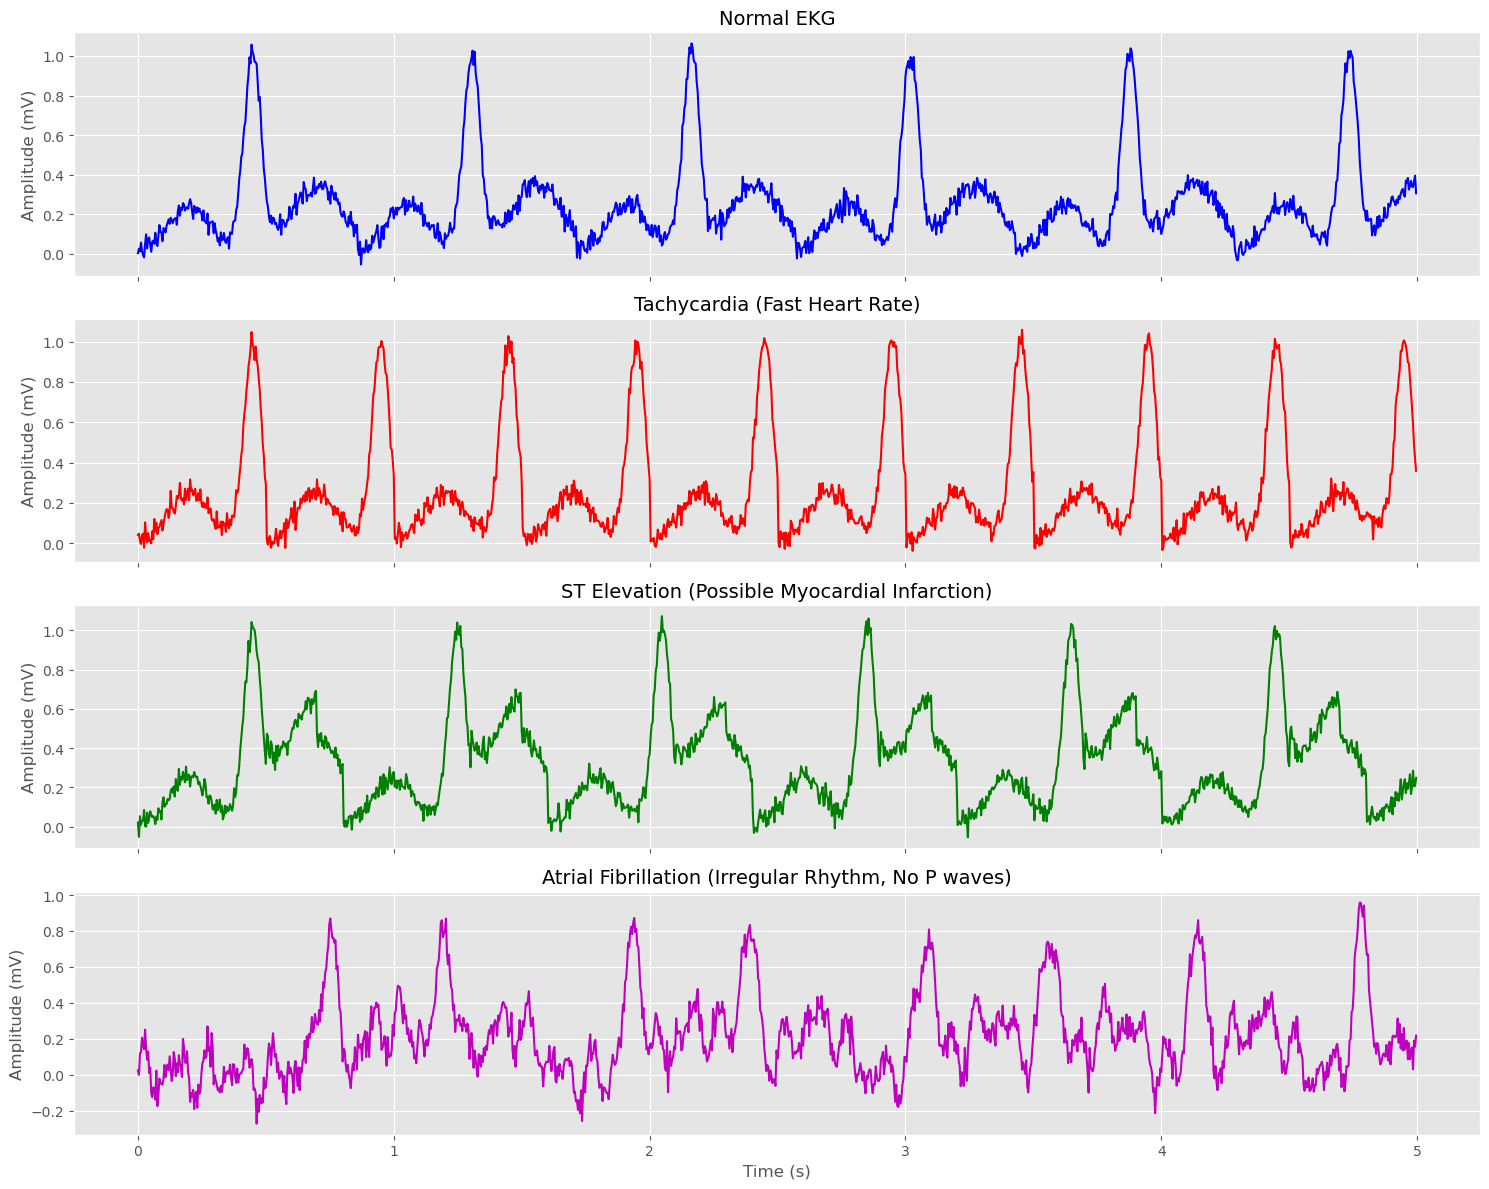

In [27]:
# Generate different EKG signals
time, ecg_normal = generate_ecg(duration=5)
time, ecg_tachycardia = generate_tachycardia_ecg(duration=5)
time, ecg_st_elevation = generate_st_elevation_ecg(duration=5)
time, ecg_afib = generate_afib_ecg(duration=5)

# Plot all EKG types
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

axes[0].plot(time, ecg_normal, 'b-')
axes[0].set_title('Normal EKG', fontsize=14)
axes[0].set_ylabel('Amplitude (mV)', fontsize=12)
axes[0].grid(True)

axes[1].plot(time, ecg_tachycardia, 'r-')
axes[1].set_title('Tachycardia (Fast Heart Rate)', fontsize=14)
axes[1].set_ylabel('Amplitude (mV)', fontsize=12)
axes[1].grid(True)

axes[2].plot(time, ecg_st_elevation, 'g-')
axes[2].set_title('ST Elevation (Possible Myocardial Infarction)', fontsize=14)
axes[2].set_ylabel('Amplitude (mV)', fontsize=12)
axes[2].grid(True)

axes[3].plot(time, ecg_afib, 'm-')
axes[3].set_title('Atrial Fibrillation (Irregular Rhythm, No P waves)', fontsize=14)
axes[3].set_xlabel('Time (s)', fontsize=12)
axes[3].set_ylabel('Amplitude (mV)', fontsize=12)
axes[3].grid(True)

plt.tight_layout()
plt.show()

## Local Extrema in EKG Analysis

Local extrema are points where the function changes from increasing to decreasing (local maximum) or from decreasing to increasing (local minimum). In EKG interpretation, these points are crucial for identifying key features.

Let's implement a function to find local extrema in our EKG signal:

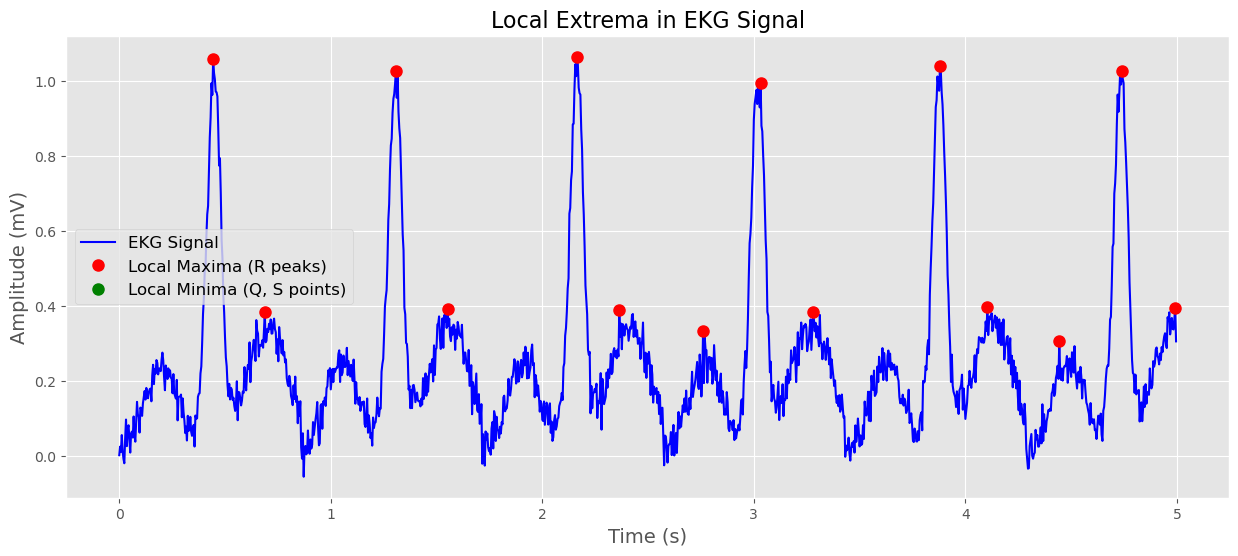

In [28]:
def find_local_extrema(signal, fs=250):
    """
    Find local extrema (maxima and minima) in an EKG signal
    
    Parameters:
    signal: EKG signal array
    fs: Sampling frequency
    
    Returns:
    tuple: (maxima_indices, maxima_values, minima_indices, minima_values)
    """
    # Find maxima
    maxima_indices, _ = find_peaks(signal, height=0.3, distance=fs*0.2)
    maxima_values = signal[maxima_indices]
    
    # Find minima - invert signal to find minima as peaks
    minima_indices, _ = find_peaks(-signal, height=0.1, distance=fs*0.1)
    minima_values = signal[minima_indices]
    
    return maxima_indices, maxima_values, minima_indices, minima_values

# Find and plot local extrema for normal EKG
max_idx, max_val, min_idx, min_val = find_local_extrema(ecg_normal)

plt.figure(figsize=(15, 6))
plt.plot(time, ecg_normal, 'b-', label='EKG Signal')
plt.plot(time[max_idx], max_val, 'ro', markersize=8, label='Local Maxima (R peaks)')
plt.plot(time[min_idx], min_val, 'go', markersize=8, label='Local Minima (Q, S points)')

plt.title('Local Extrema in EKG Signal', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude (mV)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

We can calculate the derivative to better understand the rate of change in our EKG signal:

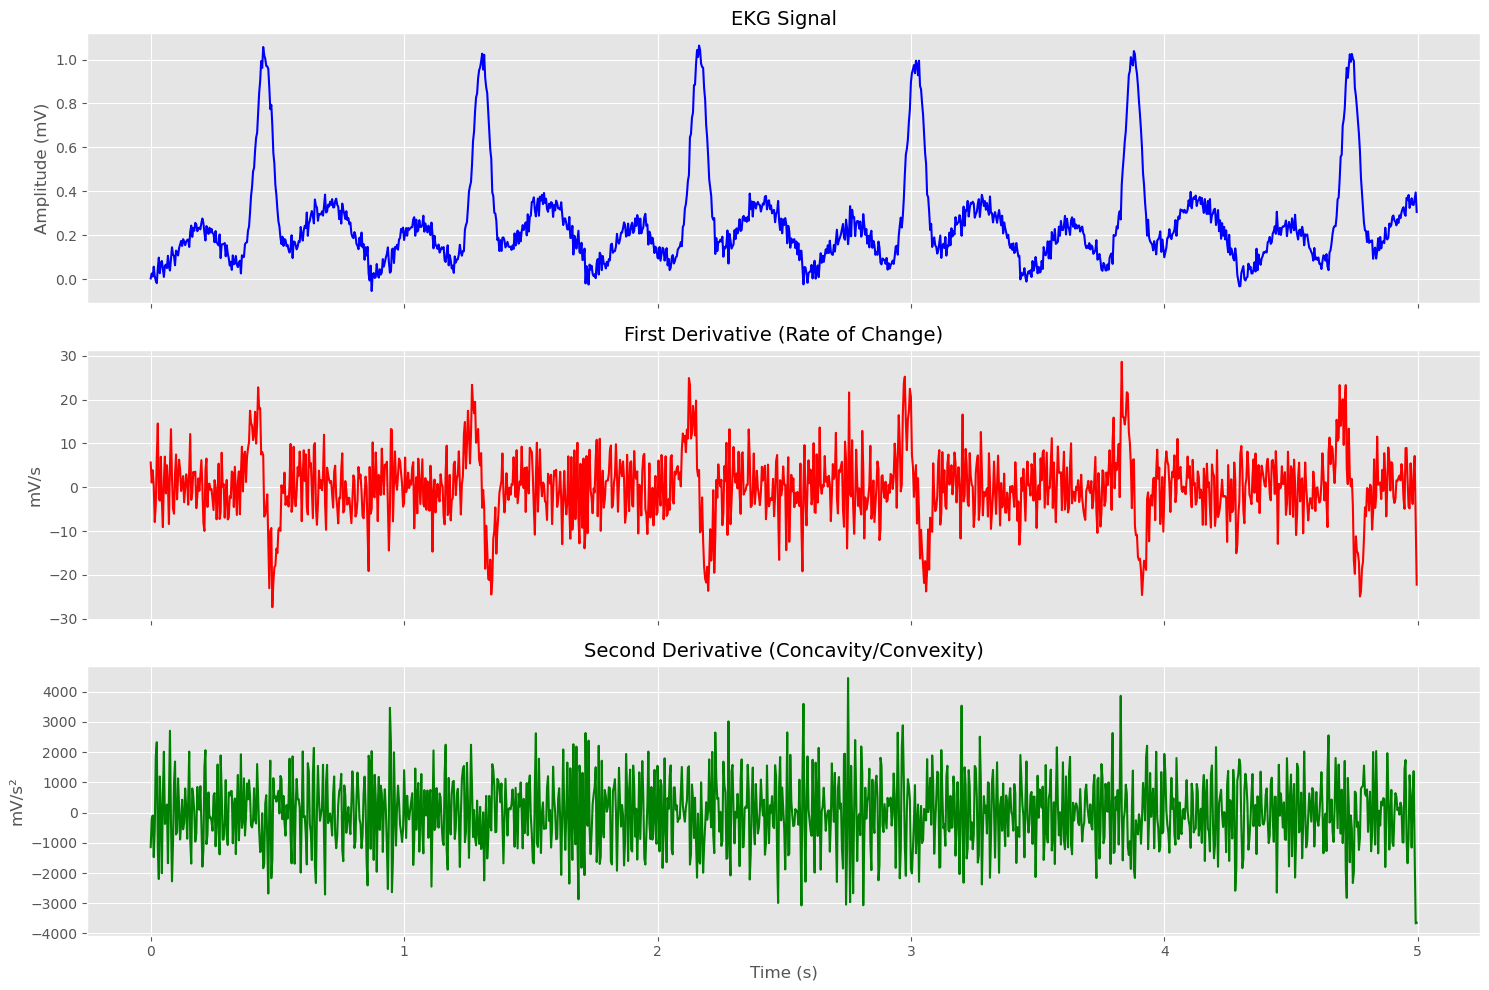

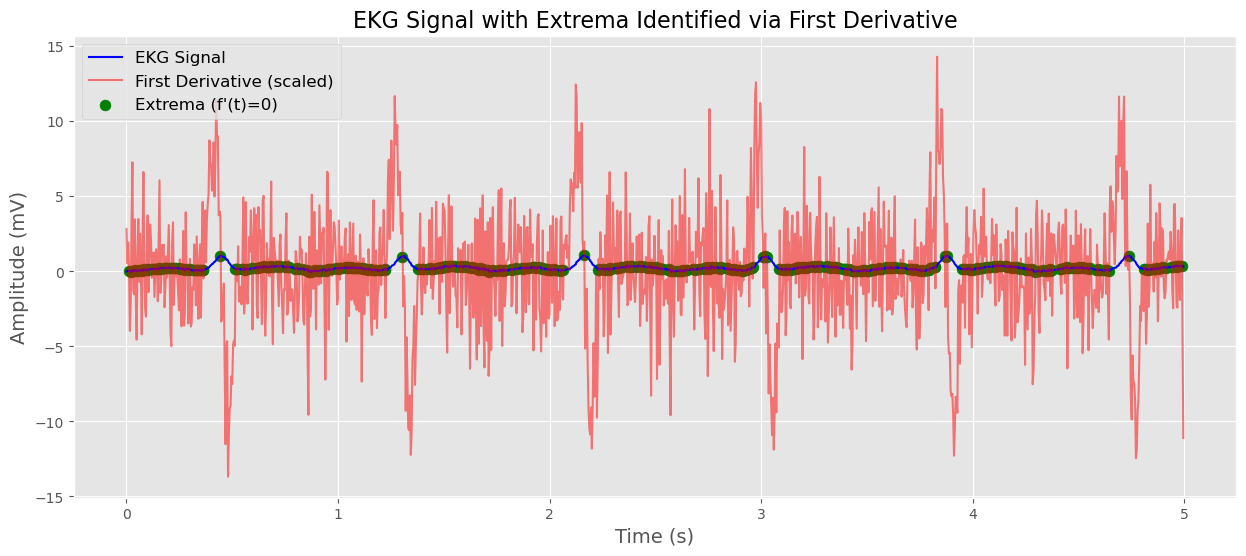

In [29]:
def calculate_derivatives(signal, fs=250):
    """
    Calculate first and second derivatives of an EKG signal
    
    Parameters:
    signal: EKG signal array
    fs: Sampling frequency
    
    Returns:
    tuple: (first_derivative, second_derivative)
    """
    # Calculate first derivative (velocity)
    first_derivative = np.gradient(signal) * fs
    
    # Calculate second derivative (acceleration)
    second_derivative = np.gradient(first_derivative) * fs
    
    return first_derivative, second_derivative

# Calculate derivatives for normal EKG
first_deriv, second_deriv = calculate_derivatives(ecg_normal)

# Plot signal and its derivatives
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

axes[0].plot(time, ecg_normal, 'b-')
axes[0].set_title('EKG Signal', fontsize=14)
axes[0].set_ylabel('Amplitude (mV)', fontsize=12)
axes[0].grid(True)

axes[1].plot(time, first_deriv, 'r-')
axes[1].set_title('First Derivative (Rate of Change)', fontsize=14)
axes[1].set_ylabel('mV/s', fontsize=12)
axes[1].grid(True)

axes[2].plot(time, second_deriv, 'g-')
axes[2].set_title('Second Derivative (Concavity/Convexity)', fontsize=14)
axes[2].set_xlabel('Time (s)', fontsize=12)
axes[2].set_ylabel('mV/s²', fontsize=12)
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Highlight zero crossings in first derivative (extrema)
zero_crossings = np.where(np.diff(np.signbit(first_deriv)))[0]

plt.figure(figsize=(15, 6))
plt.plot(time, ecg_normal, 'b-', label='EKG Signal')
plt.plot(time, first_deriv * 0.5, 'r-', alpha=0.5, label='First Derivative (scaled)')
plt.scatter(time[zero_crossings], ecg_normal[zero_crossings], color='green', s=60, label='Extrema (f\'(t)=0)')

plt.title('EKG Signal with Extrema Identified via First Derivative', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude (mV)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## Convexity and Concavity in EKG Analysis

The second derivative helps us understand the convexity and concavity of the EKG signal:
- Where second derivative > 0: Signal is concave up (accelerating upward)
- Where second derivative < 0: Signal is concave down (decelerating or accelerating downward)

Let's visualize these regions:


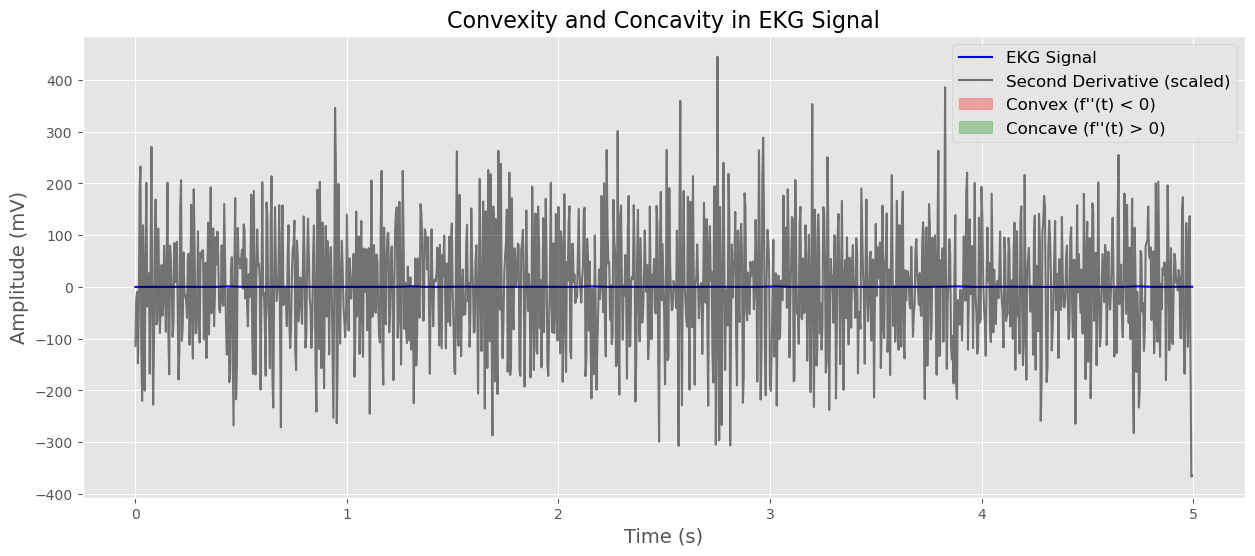

In [30]:
# Identify convex and concave regions
convex_regions = second_deriv < 0
concave_regions = second_deriv > 0

plt.figure(figsize=(15, 6))
plt.plot(time, ecg_normal, 'b-', label='EKG Signal')

# Plot second derivative (scaled for visibility)
plt.plot(time, second_deriv * 0.1, 'k-', alpha=0.5, label='Second Derivative (scaled)')

# Highlight convex and concave regions
plt.fill_between(time, ecg_normal, 0, where=convex_regions, color='red', alpha=0.3, label='Convex (f\'\'(t) < 0)')
plt.fill_between(time, ecg_normal, 0, where=concave_regions, color='green', alpha=0.3, label='Concave (f\'\'(t) > 0)')

plt.title('Convexity and Concavity in EKG Signal', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude (mV)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## Clinical Applications of Calculus in EKG Analysis

### Heart Rate Calculation Using R-R Intervals

We can use the R peaks (local maxima) to calculate heart rate:

In [31]:
def calculate_heart_rate(r_peak_indices, fs=250):
    """
    Calculate heart rate from R peak indices
    
    Parameters:
    r_peak_indices: Array of indices where R peaks occur
    fs: Sampling frequency
    
    Returns:
    tuple: (instantaneous_hr, average_hr)
    """
    # Calculate time between consecutive R peaks (in seconds)
    rr_intervals = np.diff(r_peak_indices) / fs
    
    # Convert to instantaneous heart rate (beats per minute)
    instantaneous_hr = 60 / rr_intervals
    
    # Calculate average heart rate
    average_hr = np.mean(instantaneous_hr)
    
    return instantaneous_hr, average_hr

# Calculate heart rate for different EKG types
max_idx_normal, _, _, _ = find_local_extrema(ecg_normal)
max_idx_tachy, _, _, _ = find_local_extrema(ecg_tachycardia)
max_idx_stele, _, _, _ = find_local_extrema(ecg_st_elevation)
max_idx_afib, _, _, _ = find_local_extrema(ecg_afib)

_, avg_hr_normal = calculate_heart_rate(max_idx_normal)
_, avg_hr_tachy = calculate_heart_rate(max_idx_tachy)
_, avg_hr_stele = calculate_heart_rate(max_idx_stele)
_, avg_hr_afib = calculate_heart_rate(max_idx_afib)

print(f"Average Heart Rate (Normal): {avg_hr_normal:.1f} bpm")
print(f"Average Heart Rate (Tachycardia): {avg_hr_tachy:.1f} bpm")
print(f"Average Heart Rate (ST Elevation): {avg_hr_stele:.1f} bpm")
print(f"Average Heart Rate (A-Fib): {avg_hr_afib:.1f} bpm")

Average Heart Rate (Normal): 198.9 bpm
Average Heart Rate (Tachycardia): 209.2 bpm
Average Heart Rate (ST Elevation): 217.2 bpm
Average Heart Rate (A-Fib): 207.7 bpm


### Heart Rate Variability Analysis

Heart Rate Variability (HRV) is an important metric for assessing autonomic nervous system function and stress levels:

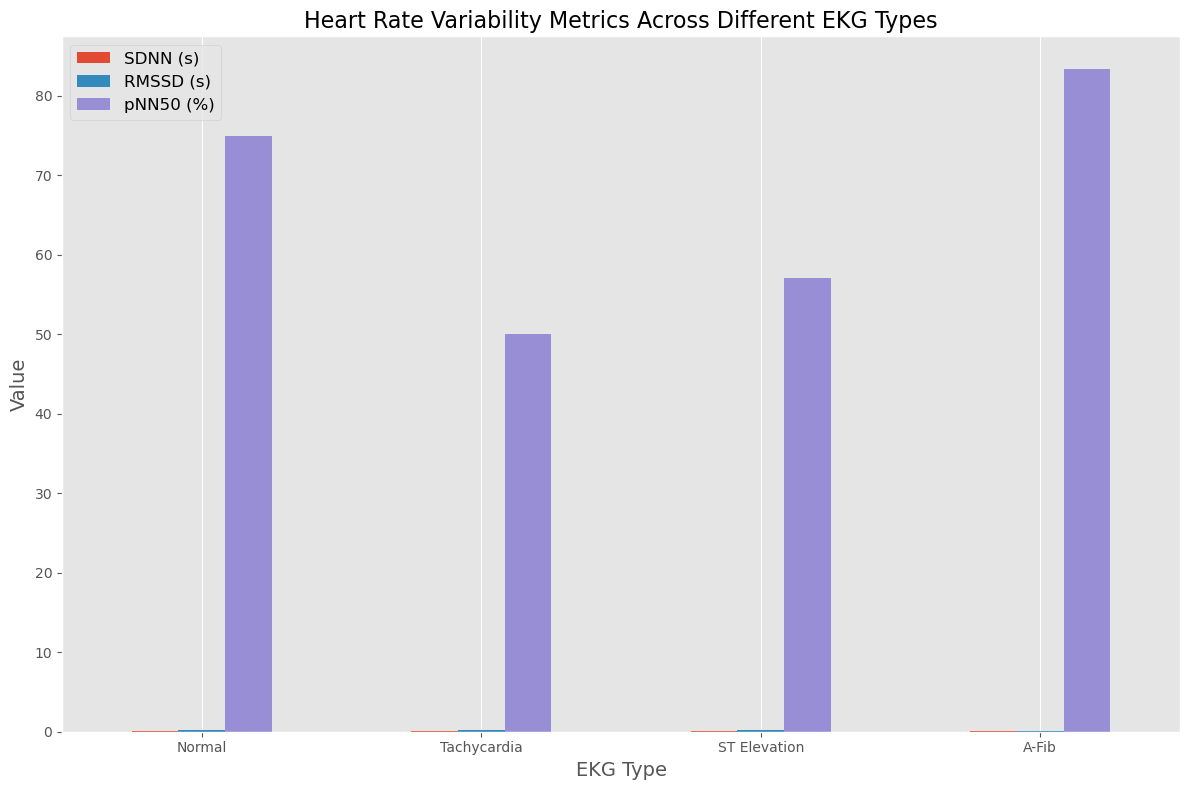

In [32]:
def calculate_hrv_metrics(r_peak_indices, fs=250):
    """
    Calculate Heart Rate Variability metrics
    
    Parameters:
    r_peak_indices: Array of indices where R peaks occur
    fs: Sampling frequency
    
    Returns:
    dict: Dictionary of HRV metrics
    """
    # Calculate RR intervals in seconds
    rr_intervals = np.diff(r_peak_indices) / fs
    
    # Time domain metrics
    sdnn = np.std(rr_intervals)  # Standard deviation of NN intervals
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))  # Root mean square of successive differences
    
    # Calculate pNN50: percentage of successive RR intervals that differ by more than 50 ms
    differences = np.abs(np.diff(rr_intervals))
    pnn50 = 100 * np.sum(differences > 0.05) / len(differences)
    
    return {
        'SDNN': sdnn,
        'RMSSD': rmssd,
        'pNN50': pnn50
    }

# Calculate HRV metrics for different EKG types
hrv_normal = calculate_hrv_metrics(max_idx_normal)
hrv_tachy = calculate_hrv_metrics(max_idx_tachy)
hrv_stele = calculate_hrv_metrics(max_idx_stele)
hrv_afib = calculate_hrv_metrics(max_idx_afib)

# Create DataFrame for comparison
hrv_df = pd.DataFrame({
    'Normal': [hrv_normal['SDNN'], hrv_normal['RMSSD'], hrv_normal['pNN50']],
    'Tachycardia': [hrv_tachy['SDNN'], hrv_tachy['RMSSD'], hrv_tachy['pNN50']],
    'ST Elevation': [hrv_stele['SDNN'], hrv_stele['RMSSD'], hrv_stele['pNN50']],
    'A-Fib': [hrv_afib['SDNN'], hrv_afib['RMSSD'], hrv_afib['pNN50']]
}, index=['SDNN (s)', 'RMSSD (s)', 'pNN50 (%)'])

# Visualize HRV metrics
plt.figure(figsize=(12, 8))
hrv_df.T.plot(kind='bar', ax=plt.gca())
plt.title('Heart Rate Variability Metrics Across Different EKG Types', fontsize=16)
plt.ylabel('Value', fontsize=14)
plt.xlabel('EKG Type', fontsize=14)
plt.xticks(rotation=0)
plt.legend(fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### ST Segment Analysis for Myocardial Ischemia

The ST segment is crucial for detecting myocardial ischemia and infarction:

Average ST Deviation (Normal): 0.195 mV
Average ST Deviation (Tachycardia): 0.075 mV
Average ST Deviation (ST Elevation): 0.293 mV
Average ST Deviation (A-Fib): 0.176 mV


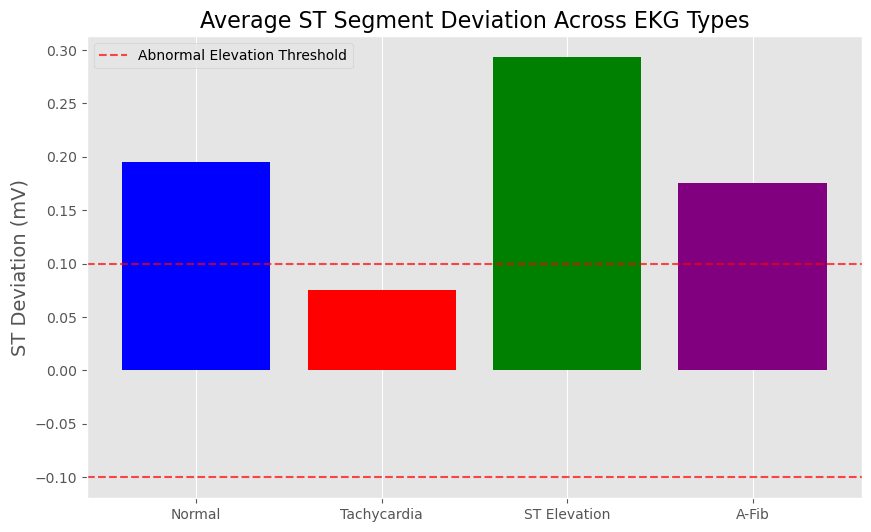

In [33]:
def analyze_st_segment(signal, r_peak_indices, fs=250):
    """
    Analyze ST segment elevation or depression
    
    Parameters:
    signal: EKG signal array
    r_peak_indices: Array of indices where R peaks occur
    fs: Sampling frequency
    
    Returns:
    tuple: (st_deviations, average_st_deviation)
    """
    st_deviations = []
    
    for r_idx in r_peak_indices:
        # ST segment typically starts about 80ms after R peak
        st_start_idx = r_idx + int(0.08 * fs)
        
        # Check if index is within signal bounds
        if st_start_idx + int(0.1 * fs) >= len(signal):
            continue
            
        # Get average value in the ST segment (80-120ms after R peak)
        st_segment = signal[st_start_idx:st_start_idx + int(0.04 * fs)]
        
        # Calculate deviation from baseline (assume baseline is 0)
        st_deviation = np.mean(st_segment)
        st_deviations.append(st_deviation)
    
    average_st_deviation = np.mean(st_deviations) if st_deviations else 0
    
    return st_deviations, average_st_deviation

# Analyze ST segments for different EKG types
_, avg_st_normal = analyze_st_segment(ecg_normal, max_idx_normal)
_, avg_st_tachy = analyze_st_segment(ecg_tachycardia, max_idx_tachy)
_, avg_st_stele = analyze_st_segment(ecg_st_elevation, max_idx_stele)
_, avg_st_afib = analyze_st_segment(ecg_afib, max_idx_afib)

print(f"Average ST Deviation (Normal): {avg_st_normal:.3f} mV")
print(f"Average ST Deviation (Tachycardia): {avg_st_tachy:.3f} mV")
print(f"Average ST Deviation (ST Elevation): {avg_st_stele:.3f} mV")
print(f"Average ST Deviation (A-Fib): {avg_st_afib:.3f} mV")

# Visualize ST segment differences
plt.figure(figsize=(10, 6))
ekg_types = ['Normal', 'Tachycardia', 'ST Elevation', 'A-Fib']
st_values = [avg_st_normal, avg_st_tachy, avg_st_stele, avg_st_afib]

bars = plt.bar(ekg_types, st_values, color=['blue', 'red', 'green', 'purple'])
plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.7, label='Abnormal Elevation Threshold')
plt.axhline(y=-0.1, color='r', linestyle='--', alpha=0.7)

plt.title('Average ST Segment Deviation Across EKG Types', fontsize=16)
plt.ylabel('ST Deviation (mV)', fontsize=14)
plt.grid(axis='y')
plt.legend()
plt.show()

## Advanced Applications: Machine Learning for EKG Analysis

### Feature Extraction from EKG Signals

In [ ]:


def extract_features(signal, fs=250):
    """
    Extract features from an EKG signal for machine learning
    
    Parameters:
    signal: EKG signal array
    fs: Sampling frequency
    
    Returns:
    dict: Dictionary of features
    """
    # Find R peaks
    r_peaks, _, _, _ = find_local_extrema(signal)
    
    # Basic statistical features
    mean = np.mean(signal)
    std = np.std(signal)
    skewness = np.mean(((signal - mean) / std) ** 3) if std > 0 else 0
    kurtosis = np.mean(((signal - mean) / std) ** 4) - 3 if std > 0 else 0
    
    # Calculate derivatives
    first_deriv, second_deriv = calculate_derivatives(signal, fs)
    
    # Heart rate and HRV features
    if len(r_peaks) > 1:
        _, avg_hr = calculate_heart_rate(r_peaks, fs)
        hrv_metrics = calculate_hrv_metrics(r_peaks, fs)
    else:
        avg_hr = 0
        hrv_metrics = {'SDNN': 0, 'RMSSD': 0, 'pNN50': 0}
    
    # ST segment analysis
    _, avg_st = analyze_st_segment(signal, r_peaks, fs)
    
    # Energy features
    energy = np.sum(signal ** 2)
    
    # Frequency domain features
    freqs, psd = welch(signal, fs, nperseg=fs)
    peak_freq = freqs[np.argmax(psd)]
    total_power = np.sum(psd)
    
    # Collect all features
    features = {
        'mean': mean,
        'std': std,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'first_deriv_mean': np.mean(np.abs(first_deriv)),
        'second_deriv_mean': np.mean(np.abs(second_deriv)),
        'heart_rate': avg_hr,
        'hrv_sdnn': hrv_metrics['SDNN'],
        'hrv_rmssd': hrv_metrics['RMSSD'],
        'st_deviation': avg_st,
        'energy': energy,
        'peak_frequency': peak_freq,
        'total_power': total_power
                                }
    return features

# Extract features from different EKG types

In [45]:
features_normal = extract_features(ecg_normal)
features_tachy = extract_features(ecg_tachycardia)
features_stele = extract_features(ecg_st_elevation)
features_afib = extract_features(ecg_afib)

# Create DataFrame for comparison

In [47]:
features_df = pd.DataFrame({
    'Normal': list(features_normal.values()),
    'Tachycardia': list(features_tachy.values()),
    'ST Elevation': list(features_stele.values()),
    'A-Fib': list(features_afib.values())
}, index=list(features_normal.keys()))

# Display features
features_df

### Visualizing EKG Features with PCA

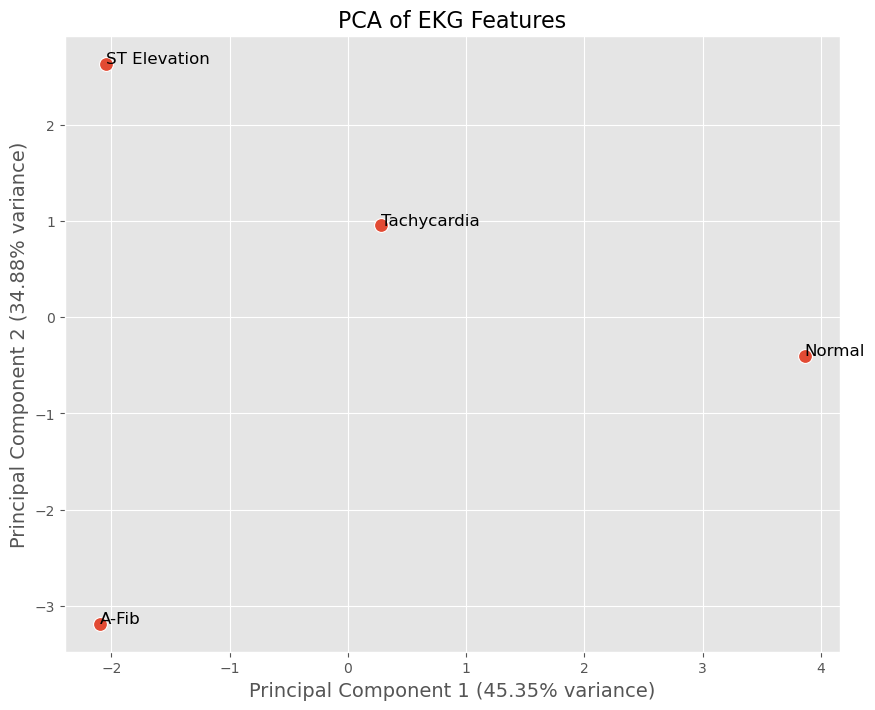

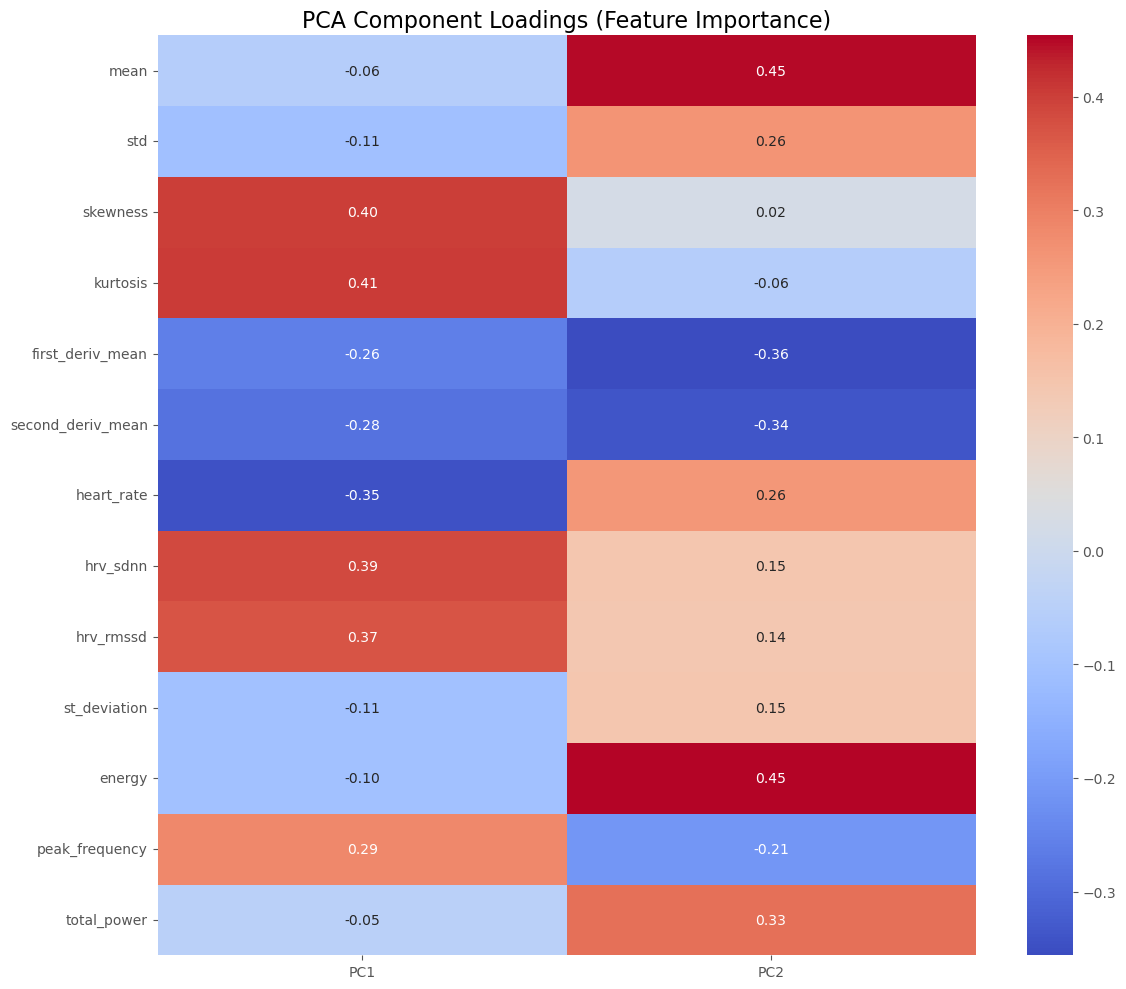

In [48]:
# Prepare data for PCA
feature_names = list(features_normal.keys())
X = np.array([
    list(features_normal.values()),
    list(features_tachy.values()),
    list(features_stele.values()),
    list(features_afib.values())
])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame(
    X_pca, 
    columns=['PC1', 'PC2'],
    index=['Normal', 'Tachycardia', 'ST Elevation', 'A-Fib']
)

# Plot PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100)

# Add labels for each point
for i, txt in enumerate(pca_df.index):
    plt.annotate(txt, (pca_df.iloc[i, 0], pca_df.iloc[i, 1]), fontsize=12)

plt.title('PCA of EKG Features', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=14)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=14)
plt.grid(True)
plt.show()

# Feature importance in PCA
component_df = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'],
    index=feature_names
)

plt.figure(figsize=(12, 10))
sns.heatmap(component_df, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('PCA Component Loadings (Feature Importance)', fontsize=16)
plt.tight_layout()
plt.show()

## Applications in Pulse Oximetry and Stress Detection

### Simulating Pulse Oximetry Measurement

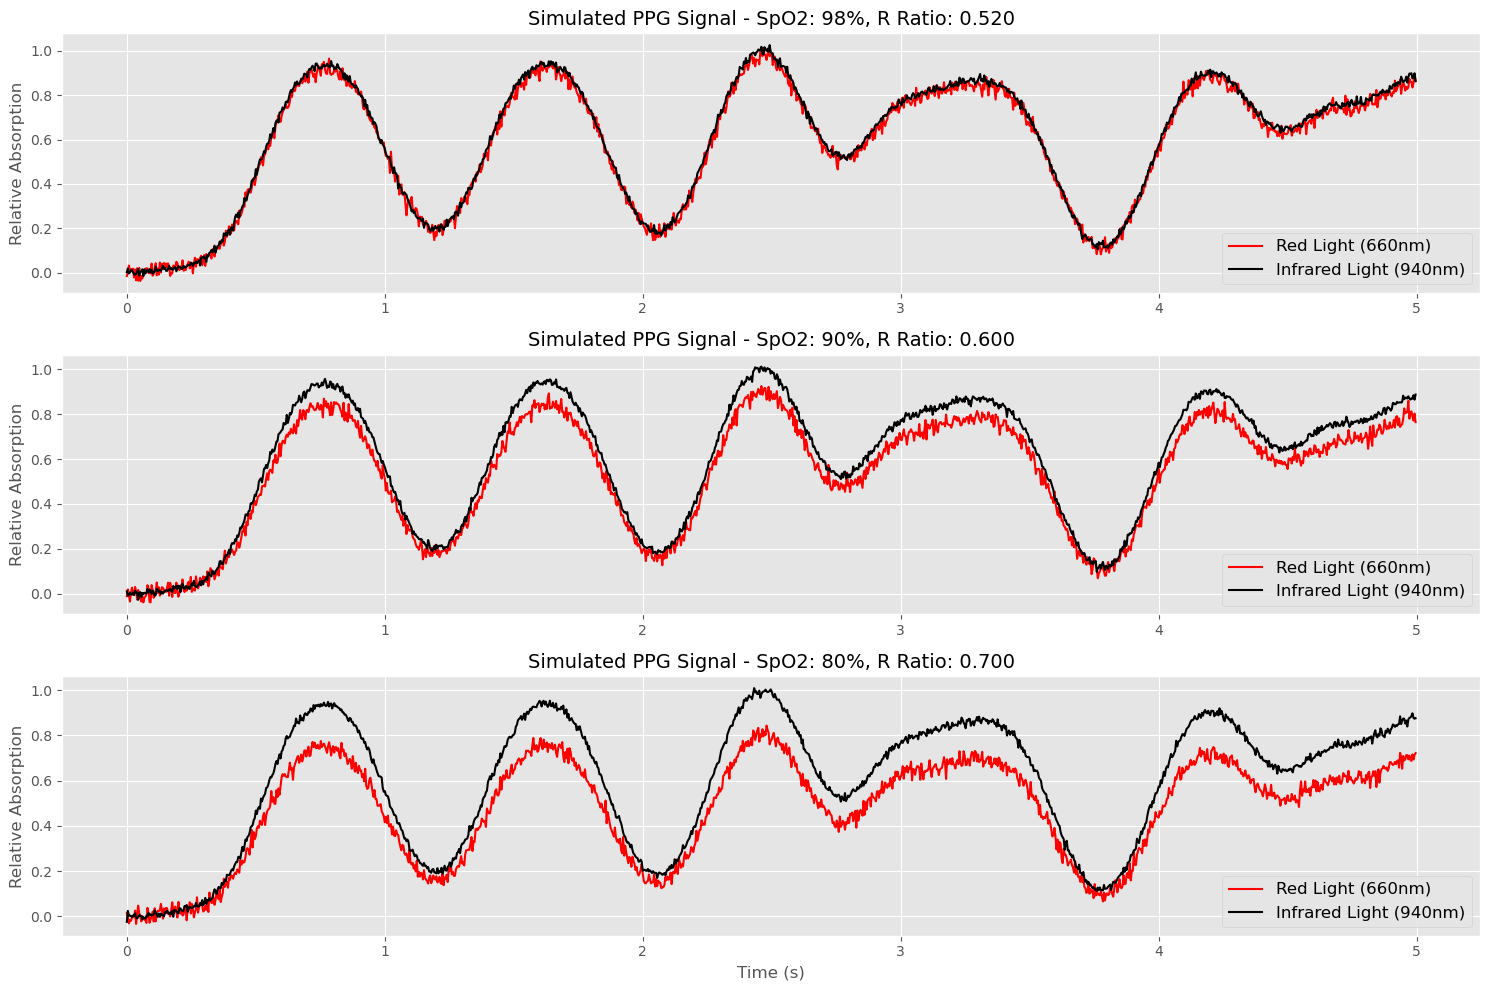

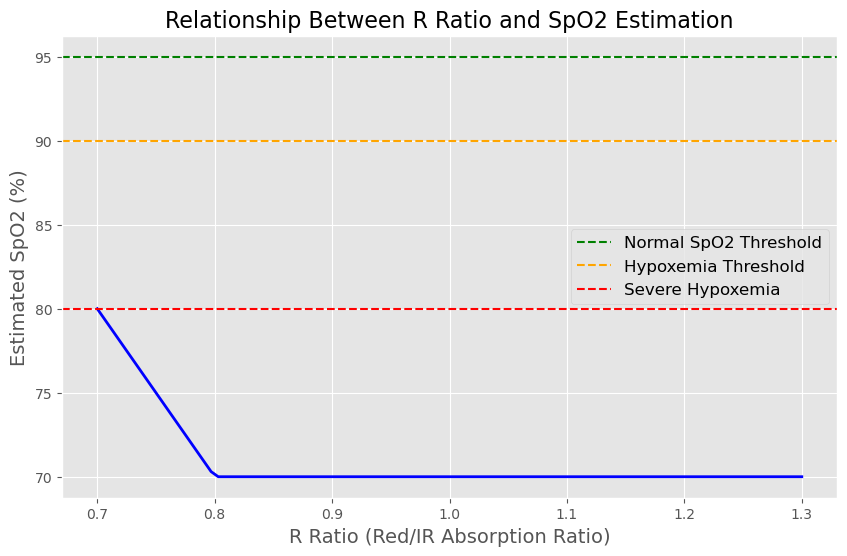

In [49]:
def simulate_ppg_signal(ecg_signal, oxygen_saturation=98, fs=250):
    """
    Simulate a photoplethysmography (PPG) signal based on ECG
    PPG signals are used in pulse oximetry
    
    Parameters:
    ecg_signal: ECG signal array
    oxygen_saturation: SpO2 level (%)
    fs: Sampling frequency
    
    Returns:
    tuple: (red_signal, ir_signal, ratio)
    """
    # Find R peaks to synchronize PPG signal
    r_peaks, _, _, _ = find_local_extrema(ecg_signal)
    
    # PPG signal is delayed and more rounded compared to ECG
    time = np.arange(len(ecg_signal)) / fs
    ppg_base = np.zeros_like(time)
    
    # Create a base PPG signal
    for peak_idx in r_peaks:
        # PPG peak occurs ~0.2s after R peak
        peak_time = time[peak_idx] + 0.2
        
        # Create a pulse wave for each heartbeat
        pulse = 1.2 * np.exp(-((time - peak_time) ** 2) / (2 * 0.15 ** 2))
        ppg_base += pulse
    
    # Add respiratory modulation
    resp_mod = 0.1 * np.sin(2 * np.pi * 0.2 * time)  # ~12 breaths per minute
    ppg_base += resp_mod
    
    # Normalize to 0-1 range
    ppg_base = (ppg_base - np.min(ppg_base)) / (np.max(ppg_base) - np.min(ppg_base))
    
    # Simulate light absorption based on oxygen saturation
    # Beer-Lambert Law: light absorption depends on concentration
    # Low SpO2 -> more absorption difference between red and IR
    # High SpO2 -> less absorption difference
    
    # Calculate ratio based on SpO2
    # Empirical relationship: R = a - b*SpO2 (where a and b are calibration constants)
    a, b = 1.5, 0.01  # Simplified constants
    ratio = a - b * oxygen_saturation
    
    # Generate red and infrared signals
    red_signal = ppg_base * (1 - 0.3 * (100 - oxygen_saturation)/30)  # Red light (more affected by SpO2)
    ir_signal = ppg_base  # Infrared light (relatively constant)
    
    # Add noise
    red_noise = np.random.normal(0, 0.02, size=len(time))
    ir_noise = np.random.normal(0, 0.01, size=len(time))
    red_signal += red_noise
    ir_signal += ir_noise
    
    return red_signal, ir_signal, ratio

# Simulate PPG signals for different oxygen saturation levels
spo2_levels = [98, 90, 80]
ecg = ecg_normal  # Use normal ECG as base

plt.figure(figsize=(15, 10))

for i, spo2 in enumerate(spo2_levels):
    red, ir, ratio = simulate_ppg_signal(ecg, oxygen_saturation=spo2)
    
    plt.subplot(3, 1, i+1)
    plt.plot(time, red, 'r-', label='Red Light (660nm)')
    plt.plot(time, ir, 'k-', label='Infrared Light (940nm)')
    plt.title(f'Simulated PPG Signal - SpO2: {spo2}%, R Ratio: {ratio:.3f}', fontsize=14)
    plt.ylabel('Relative Absorption', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)

plt.xlabel('Time (s)', fontsize=12)
plt.tight_layout()
plt.show()

# Function to estimate SpO2 from red/IR ratio
def estimate_spo2(ratio):
    """Estimate SpO2 from red/IR ratio using empirical formula"""
    # Using the inverse of the relationship from simulate_ppg_signal
    a, b = 1.5, 0.01
    spo2 = (a - ratio) / b
    # Constrain to realistic values
    return max(min(spo2, 100), 70)

# Create a range of ratios
ratios = np.linspace(0.7, 1.3, 100)
spo2_estimates = [estimate_spo2(r) for r in ratios]

plt.figure(figsize=(10, 6))
plt.plot(ratios, spo2_estimates, 'b-', linewidth=2)
plt.title('Relationship Between R Ratio and SpO2 Estimation', fontsize=16)
plt.xlabel('R Ratio (Red/IR Absorption Ratio)', fontsize=14)
plt.ylabel('Estimated SpO2 (%)', fontsize=14)
plt.grid(True)
plt.axhline(y=95, color='g', linestyle='--', label='Normal SpO2 Threshold')
plt.axhline(y=90, color='orange', linestyle='--', label='Hypoxemia Threshold')
plt.axhline(y=80, color='r', linestyle='--', label='Severe Hypoxemia')
plt.legend(fontsize=12)
plt.show()

### Stress Level Detection from HRV Analysis

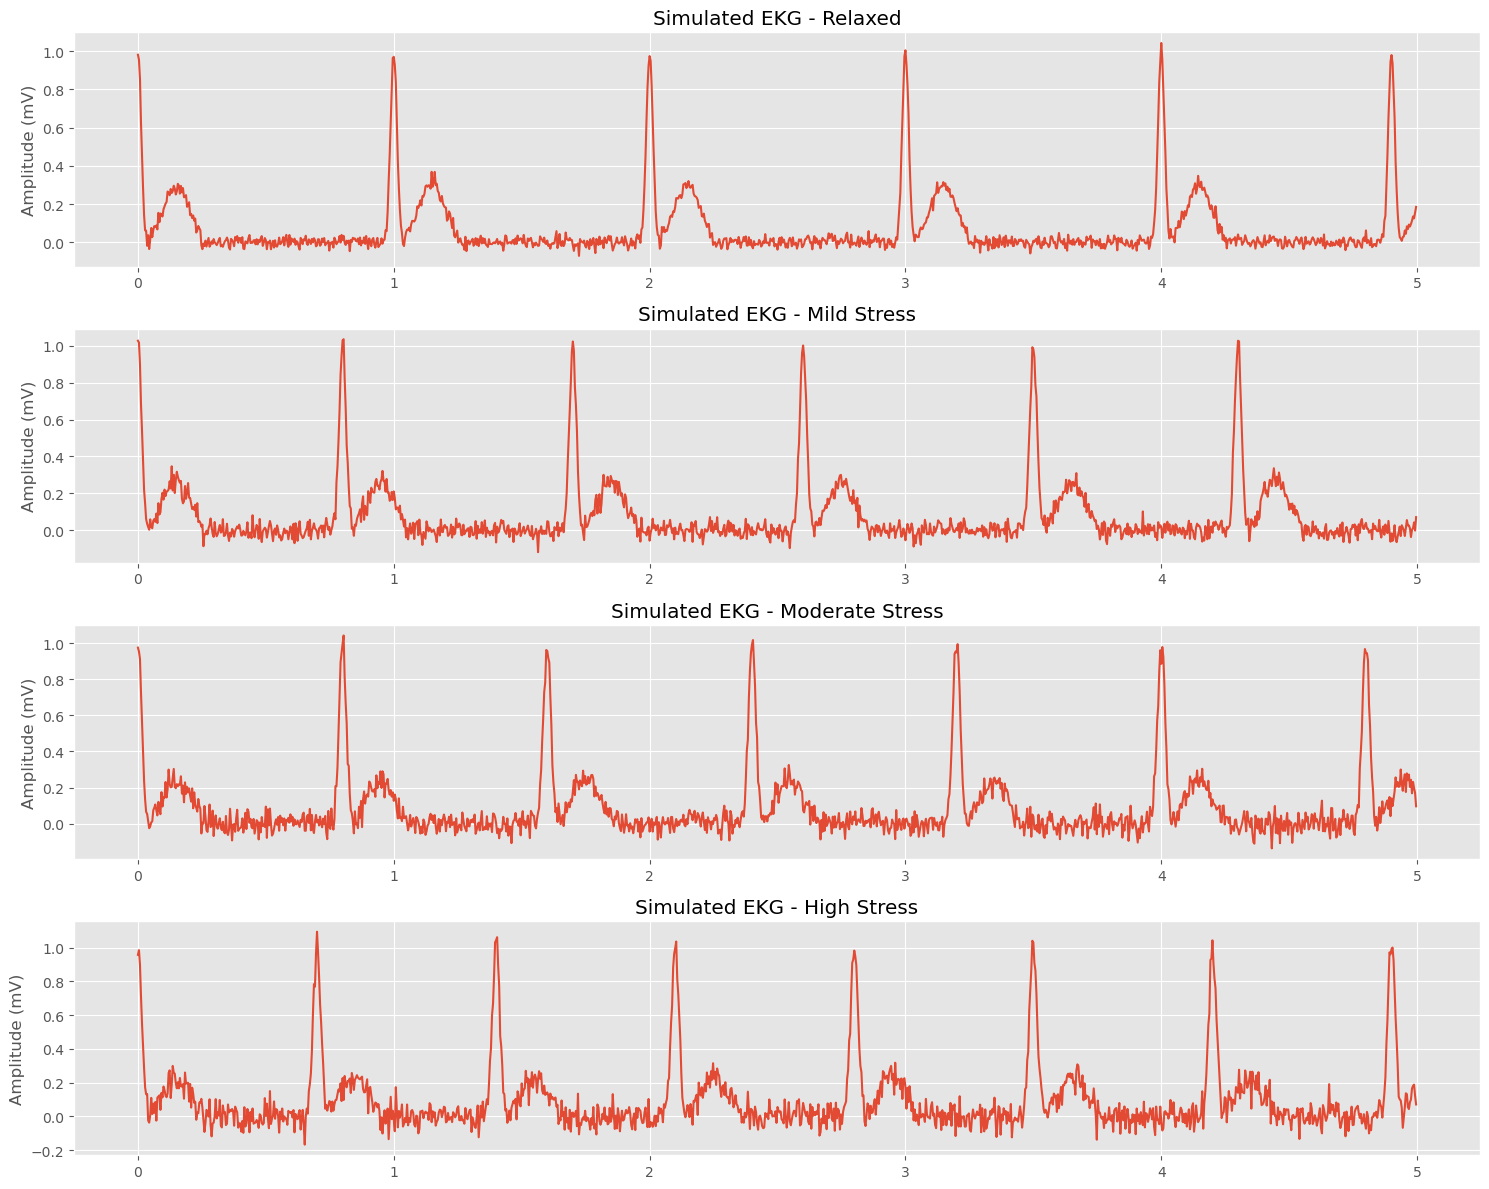

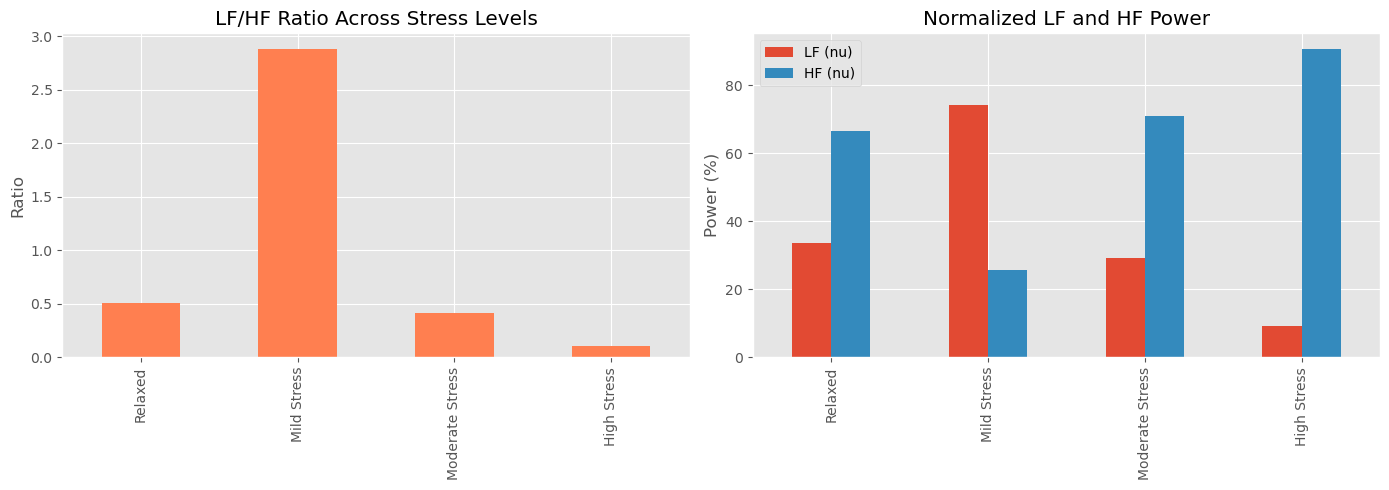

In [60]:

# Helper functions for HRV analysis
def find_local_extrema(signal):
    peaks, _ = find_peaks(signal, height=0.5, distance=50)
    return peaks, None, None, None

def calculate_hrv_metrics(r_peaks, fs=250):
    rr_intervals = np.diff(r_peaks) / fs * 1000  # Convert to ms
    
    if len(rr_intervals) < 2:
        return {'SDNN': 0, 'RMSSD': 0, 'pNN50': 0}
    
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
    pnn50 = (nn50 / len(rr_intervals)) * 100 if len(rr_intervals) > 0 else 0
    
    return {'SDNN': sdnn, 'RMSSD': rmssd, 'pNN50': pnn50}

def calculate_heart_rate(r_peaks, fs=250):
    if len(r_peaks) < 2:
        return [], 0
    
    rr_intervals = np.diff(r_peaks) / fs
    heart_rates = 60 / rr_intervals
    avg_hr = np.mean(heart_rates)
    
    return heart_rates, avg_hr

def simulate_stress_data(duration=5*60, fs=250):
    """Simulate EKG data for different stress levels"""
    time_axis = np.arange(0, duration, 1/fs)
    
    stress_levels = {
        'Relaxed': {'hr': 65, 'hrv': 0.08, 'noise': 0.02},
        'Mild Stress': {'hr': 75, 'hrv': 0.05, 'noise': 0.03},
        'Moderate Stress': {'hr': 85, 'hrv': 0.03, 'noise': 0.04},
        'High Stress': {'hr': 95, 'hrv': 0.02, 'noise': 0.05}
    }
    
    signals = {}
    
    for level, params in stress_levels.items():
        # Base heart rate with variability
        hr_base = params['hr']
        hr_var = np.zeros_like(time_axis)
        
        # Multiple frequency components for HRV
        for freq in [0.04, 0.1, 0.25]:  # VLF, LF, HF frequencies
            if freq > 0.15:  # HF component
                amplitude = params['hrv'] * (1 - 0.7 * (1 - params['hrv']/0.08))
            else:
                amplitude = params['hrv'] * (1 + 0.3 * (1 - params['hrv']/0.08))
                
            hr_var += amplitude * np.sin(2 * np.pi * freq * time_axis + np.random.rand() * 2 * np.pi)
        
        heart_rate = hr_base + hr_var * 10
        
        # Generate EKG signal
        signal_out = np.zeros_like(time_axis)
        next_beat = 0
        
        for t in np.arange(0, duration, 0.1):
            idx = int(t * fs)
            if idx >= len(heart_rate):
                break
                
            current_hr = heart_rate[idx]
            beat_interval = 60.0 / current_hr
            
            if t >= next_beat:
                beat_idx = int(t * fs)
                if beat_idx + int(0.1 * fs) >= len(signal_out):
                    continue
                    
                # QRS complex
                qrs_width = int(0.08 * fs)
                for i in range(-qrs_width, qrs_width):
                    if 0 <= beat_idx + i < len(signal_out):
                        sharpness = 20 + 10 * (1 - params['hrv']/0.08)
                        signal_out[beat_idx + i] += 1.0 * np.exp(-(i**2) / sharpness)
                
                # T wave
                t_delay = int(0.15 * fs)
                t_width = int(0.1 * fs)
                for i in range(-t_width, t_width):
                    if 0 <= beat_idx + t_delay + i < len(signal_out):
                        t_amplitude = 0.3 * (0.7 + 0.3 * params['hrv']/0.08)
                        signal_out[beat_idx + t_delay + i] += t_amplitude * np.exp(-(i**2) / (2 * (t_width/2)**2))
                
                next_beat = t + beat_interval
        
        # Add noise
        noise = np.random.normal(0, params['noise'], size=len(signal_out))
        signal_out += noise
        
        signals[level] = signal_out
    
    return signals, time_axis

# Simulate data
stress_signals, stress_time = simulate_stress_data(duration=60)

# Plotting
plt.figure(figsize=(15, 12))
for i, (level, sig) in enumerate(stress_signals.items()):
    plt.subplot(4, 1, i+1)
    segment = slice(0, 5 * 250)
    plt.plot(stress_time[segment], sig[segment])
    plt.title(f'Simulated EKG - {level}')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)
plt.tight_layout()
plt.show()

# HRV analysis
hrv_results = {}
for level, sig in stress_signals.items():
    r_peaks, _, _, _ = find_local_extrema(sig)
    if len(r_peaks) > 1:
        hrv_metrics = calculate_hrv_metrics(r_peaks)
        _, avg_hr = calculate_heart_rate(r_peaks)
        hrv_results[level] = {
            'HR': avg_hr,
            'SDNN': hrv_metrics['SDNN'],
            'RMSSD': hrv_metrics['RMSSD'],
            'pNN50': hrv_metrics['pNN50']
        }

hrv_df = pd.DataFrame(hrv_results).T

# Frequency domain analysis using scipy.signal.welch
def calculate_frequency_domain_hrv(r_peaks, fs=250):
    """Calculate frequency domain HRV metrics using scipy.signal.welch"""
    if len(r_peaks) < 4:
        return {
            'VLF': 0, 'LF': 0, 'HF': 0, 'Total Power': 0,
            'LF (nu)': 0, 'HF (nu)': 0, 'LF/HF Ratio': 0
        }
    
    rr_intervals = np.diff(r_peaks) / fs
    rr_times = np.cumsum(rr_intervals) - rr_intervals[0]
    
    # Interpolate to 4Hz
    fs_interp = 4.0
    t_interp = np.arange(0, rr_times[-1], 1/fs_interp)
    rr_interp = np.interp(t_interp, rr_times, rr_intervals)
    
    # Use scipy.signal.welch
    freqs, psd = signal.welch(rr_interp, fs_interp, nperseg=min(256, len(rr_interp)//2))
    
    # Frequency bands
    vlf = (0.003 <= freqs) & (freqs < 0.04)
    lf = (0.04 <= freqs) & (freqs < 0.15)
    hf = (0.15 <= freqs) & (freqs < 0.4)
    
    vlf_power = np.trapz(psd[vlf], freqs[vlf])
    lf_power = np.trapz(psd[lf], freqs[lf])
    hf_power = np.trapz(psd[hf], freqs[hf])
    total_power = vlf_power + lf_power + hf_power
    
    lf_nu = 100 * lf_power / (lf_power + hf_power) if (lf_power + hf_power) > 0 else 0
    hf_nu = 100 * hf_power / (lf_power + hf_power) if (lf_power + hf_power) > 0 else 0
    lf_hf_ratio = lf_power / hf_power if hf_power > 0 else 0
    
    return {
        'VLF': vlf_power,
        'LF': lf_power,
        'HF': hf_power,
        'Total Power': total_power,
        'LF (nu)': lf_nu,
        'HF (nu)': hf_nu,
        'LF/HF Ratio': lf_hf_ratio
    }

# Calculate frequency metrics
freq_results = {}
for level, sig in stress_signals.items():
    r_peaks, _, _, _ = find_local_extrema(sig)
    if len(r_peaks) > 4:
        freq_results[level] = calculate_frequency_domain_hrv(r_peaks)

freq_df = pd.DataFrame(freq_results).T

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
freq_df['LF/HF Ratio'].plot(kind='bar', ax=ax[0], color='coral')
ax[0].set_title('LF/HF Ratio Across Stress Levels')
ax[0].set_ylabel('Ratio')

freq_df[['LF (nu)', 'HF (nu)']].plot(kind='bar', ax=ax[1])
ax[1].set_title('Normalized LF and HF Power')
ax[1].set_ylabel('Power (%)')

plt.tight_layout()
plt.show()

## Disease Classification from EKG Data

Let's create a simple example of how machine learning could be used to classify EKG patterns:

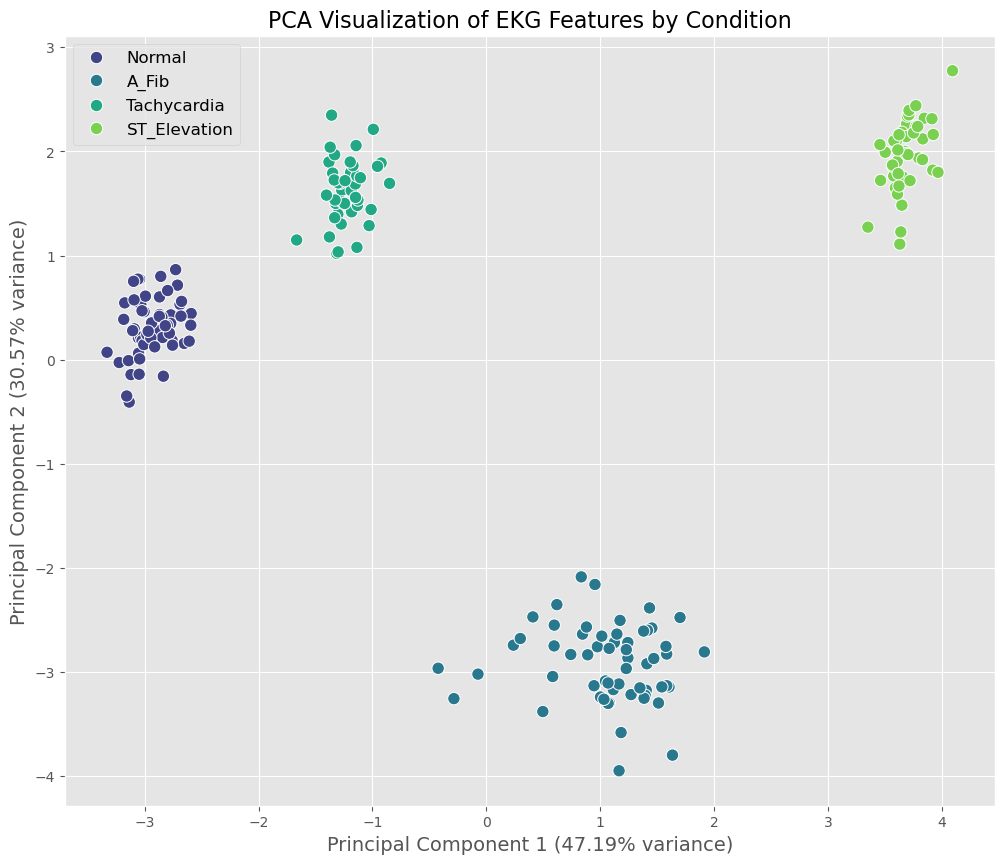

Classification Report:
              precision    recall  f1-score   support

       A_Fib       1.00      1.00      1.00        17
      Normal       1.00      1.00      1.00        17
ST_Elevation       1.00      1.00      1.00        13
 Tachycardia       1.00      1.00      1.00        13

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



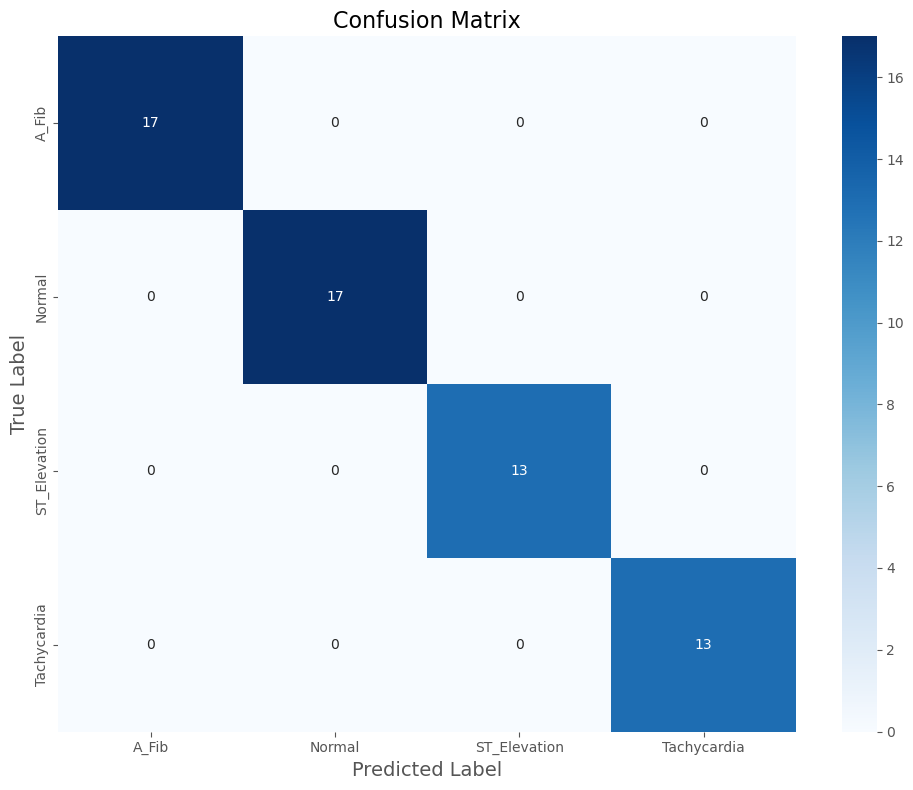

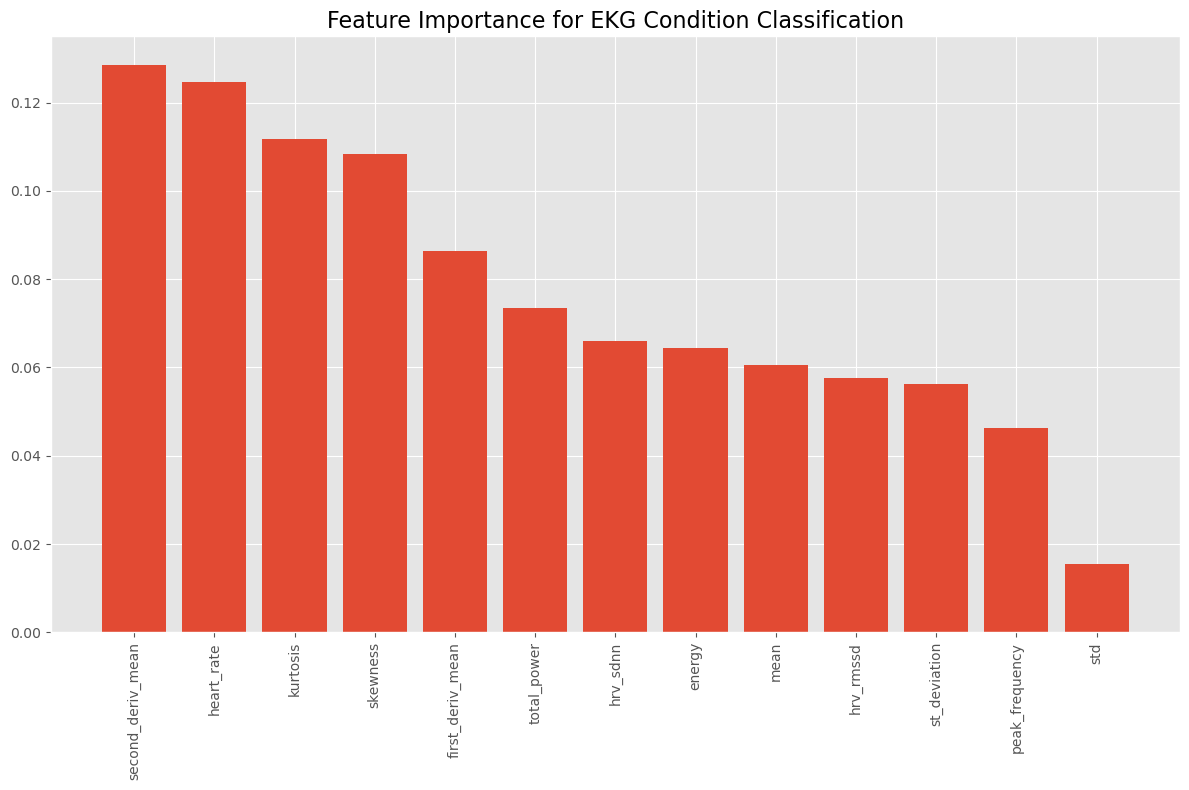

In [61]:
# Generate a larger dataset of synthetic EKG signals
def generate_dataset(n_samples=100):
    """Generate synthetic EKG dataset with different conditions"""
    X = []
    y = []
    classes = ['Normal', 'Tachycardia', 'ST_Elevation', 'A_Fib']
    
    for _ in range(n_samples):
        # Randomly choose a class with equal probability
        class_idx = np.random.randint(0, 4)
        class_name = classes[class_idx]
        
        # Generate appropriate EKG signal
        if class_name == 'Normal':
            _, signal = generate_ecg(duration=5)
        elif class_name == 'Tachycardia':
            _, signal = generate_tachycardia_ecg(duration=5)
        elif class_name == 'ST_Elevation':
            _, signal = generate_st_elevation_ecg(duration=5)
        else:  # A_Fib
            _, signal = generate_afib_ecg(duration=5)
            
        # Extract features
        features = extract_features(signal)
        
        # Add some variability
        for key in features:
            features[key] *= np.random.uniform(0.9, 1.1)
            
        X.append(list(features.values()))
        y.append(class_name)
        
    return np.array(X), np.array(y)

# Generate dataset
X, y = generate_dataset(n_samples=200)

# Visualize feature distribution with PCA
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Class'] = y

plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='Class', data=pca_df, palette='viridis', s=80)
plt.title('PCA Visualization of EKG Features by Condition', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=14)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Split data for training and testing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

# Feature importance
feature_names = list(features_normal.keys())
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importance for EKG Condition Classification', fontsize=16)
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we've explored how calculus concepts can be applied to analyze EKG data:

1. **Local Extrema (First Derivative)**
   - R peaks, Q and S points represent critical points where the EKG's first derivative equals zero
   - These extrema are essential for diagnosing cardiac conditions

2. **Convexity and Concavity (Second Derivative)**
   - Convex/concave segments provide information about acceleration/deceleration of electrical activity
   - ST segment shape analysis helps identify myocardial injury

3. **Applications**
   - Pulse oximetry uses principles of light absorption and Beer-Lambert law
   - Stress level assessment through heart rate variability analysis
   - Disease classification using machine learning techniques

The combination of calculus, signal processing, and machine learning provides powerful tools for analyzing cardiac health and detecting abnormalities in EKG data.

### ** 7. Physics Engine
Use your knowledge of vectors, algebra and calculus to create a physics engine. You can use this for many things. One example is computer games. Another example is computer simulation.

Don't forget to provide details about your calculations and implementations. 
* Implement vectors and operations
* Implement visualization
* Implement Newtonian mechanics with forces as vectors acting on material points
* Implement another physical process: e.g. collision detection. This should take into account momentum and the law of conservation of momentum
    * You can also implement other physical phenomena (e.g. heat transfer, reflection of light, etc.), as you need.